In [130]:
# load, v1 / RGB
import jax
import jax.numpy as jnp
from jax import jit
import jax.random as rnd
import numpy as np
np.set_printoptions(threshold=1000, linewidth=200)
import matplotlib
matplotlib.use('Qt5Agg')
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
import matplotlib.cm as cm
from matplotlib.patches import Ellipse
import os
import functools

def load_data(str_):
    path_ = os.path.dirname(os.getcwd()) + '/sc_project/test_data/' # Path(__file__).resolve().parents[1]
    with open(path_+str_,'rb') as file_:
        # param = pickle.load(file_)
        param_ = jnp.load(file_,allow_pickle=True)
    return param_

file_ = 'forward_new_v1_225_02_08-0732.pkl' # 'forward_new_v1_225_31_07-0617.pkl' # 'move_loop_v2_data_27_07-160547.pkl' # 'move_loop_v2_data_27_07-161313.pkl'[7] # _'move_loop_v1_26_07-093804.pkl' # move_loop_v1__25_07-161050.pkl
(arrs,aux) = load_data(file_) # # [VMAPS,STEPS,N]x2,[VMAPS,STEPS,2]x3,[VMAPS,STEPS]x2
(loss_arr,loss_sem,loss_v_arr,v_std_arr,loss_r_arr,r_std_arr) = arrs
(v_pred_arr,v_t_arr,loss_v_arr_,loss_d_arr_,pos_arr,dot_arr,rel_vec_hat_arr,opt_state,p_weights) = aux
print('loss_arr.shape=',loss_arr.shape,'loss_sem.shape=',loss_sem.shape,'loss_v_arr.shape=',loss_v_arr.shape,'v_std_arr.shape=',v_std_arr.shape,'loss_r_arr.shape=',loss_r_arr.shape,'r_std_arr.shape=',r_std_arr.shape)
print('v_pred_arr.shape=',v_pred_arr.shape,'v_t_arr.shape=',v_t_arr.shape,'loss_v_arr_.shape=',loss_v_arr_.shape,'loss_d_arr_.shape=',loss_d_arr_.shape,'pos_arr.shape=',pos_arr.shape,'dot_arr.shape=',dot_arr.shape,'rel_vec_hat_arr.shape=',rel_vec_hat_arr.shape)
rel_vec_hat_arr = jnp.concatenate([jnp.nan*jnp.zeros((500,1,2)),rel_vec_hat_arr],axis=1)

loss_arr.shape= (10000,) loss_sem.shape= (10000,) loss_v_arr.shape= (10000, 6) v_std_arr.shape= (10000, 6) loss_r_arr.shape= (10000, 6) r_std_arr.shape= (10000, 6)
v_pred_arr.shape= (500, 7, 300) v_t_arr.shape= (500, 7, 300) loss_v_arr_.shape= (500, 6) loss_d_arr_.shape= (500, 6) pos_arr.shape= (500, 2, 7) dot_arr.shape= (500, 2, 7) rel_vec_hat_arr.shape= (500, 6, 2)


/var/folders/hp/sdqbmwnd5m14lcp1k2qjnkx00000gn/T/ipykernel_11188/576464676.py:66: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  dot.set_data(mod_(dot_arr[i, 0]), mod_(dot_arr[i, 1]))
/var/folders/hp/sdqbmwnd5m14lcp1k2qjnkx00000gn/T/ipykernel_11188/576464676.py:67: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  agent.set_data(mod_(pos_arr[i, 0]), mod_(pos_arr[i, 1]))


In [131]:
# sort arrs, v1
tot_loss = jnp.sum(loss_v_arr_+loss_d_arr_, axis=1)
loss_tot_asc = jnp.argsort(tot_loss) #[::-1]
tot_loss_v = jnp.sum(loss_v_arr_, axis=1)
loss_v_asc = jnp.argsort(tot_loss_v) #[::-1]
tot_loss_d = jnp.sum(loss_d_arr_, axis=1)
loss_d_asc = jnp.argsort(tot_loss_d) #[::-1]
print('loss_tot_asc=',loss_tot_asc[:10])
print('loss_v_asc=',loss_v_asc[:10])
print('loss_d_asc=',loss_d_asc[:10])

loss_tot_asc= [417 291 224  92 147 464 172 425 215 271]
loss_v_asc= [417 291  92 231 327 224 147 172 215 464]
loss_d_asc= [137 417 261 370 311  71  28  61 127  41]


/var/folders/hp/sdqbmwnd5m14lcp1k2qjnkx00000gn/T/ipykernel_11188/576464676.py:66: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  dot.set_data(mod_(dot_arr[i, 0]), mod_(dot_arr[i, 1]))
/var/folders/hp/sdqbmwnd5m14lcp1k2qjnkx00000gn/T/ipykernel_11188/576464676.py:67: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  agent.set_data(mod_(pos_arr[i, 0]), mod_(pos_arr[i, 1]))


In [135]:
# full ani, v1
%matplotlib qt
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.animation as animation
import functools

def mod_(x):
    return (x + np.pi) % (2 * np.pi) - np.pi

def gen_vectors(MODULES, APERTURE):
    m = MODULES
    A = APERTURE
    x = np.linspace(-(A-A/m), (A-A/m), m)
    x_ = np.tile(x, (m, ))
    y_ = np.repeat(np.flip(x), m)
    return np.vstack([x_, y_])

def set_axis_properties(ax,lim,labels,title=''):
    ax.set_xlim(-lim,lim)
    ax.set_ylim(-lim,lim)
    ax.set_aspect('equal', 'box')  
    ax.set_title(title)
    ticks = np.linspace(-lim,lim,5)
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)

def get_aperture_points(agent_t,aperture,density=100):
    x_horizontal = np.linspace(agent_t[0] - aperture, agent_t[0] + aperture, density)
    y_top = np.full(density, agent_t[1] + aperture)
    y_bottom = np.full(density, agent_t[1] - aperture)
    y_vertical = np.linspace(agent_t[1] - aperture, agent_t[1] + aperture, density)
    x_left = np.full(density, agent_t[0] - aperture)
    x_right = np.full(density, agent_t[0] + aperture)
    x_tot = np.concatenate([x_left, x_right, x_horizontal, x_horizontal])
    y_tot = np.concatenate([y_vertical, y_vertical, y_bottom, y_top])
    return x_tot, y_tot

def animate(i,v_pred_arr,v_t_arr,dot_arr,dot_hat_arr,pos_arr,dot,dot_hat,agent,neuron_locs,scatters_pred,scatters_t,aperture_points,act_space_points):
    # initialize
    dot.set_data(mod_(dot_arr[i, 0]), mod_(dot_arr[i, 1]))
    agent.set_data(mod_(pos_arr[i, 0]), mod_(pos_arr[i, 1]))
    dot_hat.set_data(mod_(dot_hat_arr[i, 0]), mod_(dot_hat_arr[i, 1]))
    # aperture color
    if i == 0:
        aperture_points.set_color('green')
    else:
        aperture_points.set_color('black')
    # Update v_pred_arr
    scatters_pred.set_offsets(neuron_locs.T)
    scatters_pred.set_array(v_pred_arr[i,:,:].flatten())
    scatters_pred.set_sizes(17 * np.sum(v_pred_arr[i, :, :], axis=0))
    # Update v_t_arr
    scatters_t.set_offsets(neuron_locs.T)
    scatters_t.set_array(v_t_arr[i,:,:].flatten())
    scatters_t.set_sizes(17 * np.sum(v_t_arr[i, :, :], axis=0))
    x_aperture,y_aperture = get_aperture_points(pos_arr[i],APERTURE)
    aperture_points.set_offsets(np.c_[mod_(x_aperture), mod_(y_aperture)])
    x_act_space,y_act_space = get_aperture_points(pos_arr[i],ACT_SPACE)
    act_space_points.set_offsets(np.c_[mod_(x_act_space), mod_(y_act_space)])
    return [dot,agent,dot_hat,scatters_pred,scatters_t,aperture_points,act_space_points]

k = 1 # 20
interval = 300
STEPS = v_pred_arr.shape[1]
MODULES = 15
NEURONS = 10
APERTURE = np.pi/2
ACT_SPACE = np.pi/5

neuron_locs = gen_vectors(NEURONS,ACT_SPACE)
v_pred_arr_ = np.clip(v_pred_arr[k,:,:],0,1).reshape((STEPS,3,NEURONS**2)) #.transpose(0, 2, 1)
v_t_arr_ = v_t_arr[k,:,:].reshape((STEPS,3,NEURONS**2)) #.transpose(0, 2, 1)
dot_arr_ = dot_arr[k,:,:].T # [STEPS,2]
pos_arr_ = pos_arr[k,:,:].T # [STEPS,2]
rel_vec_hat_arr_ = rel_vec_hat_arr[k,:,:] # [STEPS,2]
dot_hat_arr_ = mod_(rel_vec_hat_arr_ + pos_arr_)

fig = plt.figure(figsize=(8, 12))
gs = gridspec.GridSpec(3, 2, height_ratios=[1, 1, 1])

ax_ani = plt.subplot(gs[0:2, 0:2],aspect='equal')
agent, = ax_ani.plot(mod_(pos_arr_[0, 0]), mod_(pos_arr_[0, 1]), 'k+', markersize=12, label='dot')
dot, = ax_ani.plot(mod_(dot_arr_[0, 0]), mod_(dot_arr_[0, 1]), 'rx', markersize=10, label='agent')
dot_hat, = ax_ani.plot(mod_(dot_hat_arr_[0, 0]), mod_(dot_hat_arr_[0, 1]), 'bx', markersize=10, label='dot_hat')

set_axis_properties(ax_ani,jnp.pi,["$-\pi$", "$-\pi/2$", "0", "$\pi/2$", "$\pi$"])

ax_pred = plt.subplot(gs[2, 0],aspect='equal')
scatters_pred = ax_pred.scatter(neuron_locs[0, :], neuron_locs[1, :], c=v_pred_arr_[0, :, :].T, s=17 * np.sum(v_pred_arr_[0, :, :], axis=0), marker='o')
set_axis_properties(ax_pred,ACT_SPACE,["$-\pi/5$", "$-\pi/10$", "0", "$\pi/10$", "$\pi/5$"],'v_pred')

ax_t = plt.subplot(gs[2, 1],aspect='equal')
scatters_t = ax_t.scatter(neuron_locs[0, :], neuron_locs[1, :], c=v_t_arr_[0, :, :].T, s=17 * np.sum(v_t_arr_[0, :, :], axis=0), marker='o')
set_axis_properties(ax_t,ACT_SPACE,["$-\pi/5$", "$-\pi/10$", "0", "$\pi/10$", "$\pi/5$"],'v_t')

aperture_points = ax_ani.scatter([], [], color='black', s=1)
act_space_points = ax_ani.scatter([], [], color='lightgrey', s=1)

partial_animate = functools.partial(
    animate,
    v_pred_arr=v_pred_arr_, 
    v_t_arr=v_t_arr_, 
    dot_arr=dot_arr_, 
    dot_hat_arr=dot_hat_arr_,
    pos_arr=pos_arr_, 
    dot=dot, 
    dot_hat=dot_hat,
    agent=agent, 
    neuron_locs=neuron_locs, 
    scatters_pred=scatters_pred, 
    scatters_t=scatters_t,
    aperture_points=aperture_points,
    act_space_points=act_space_points,
)

ani = animation.FuncAnimation(
    fig=fig, 
    func=partial_animate,
    frames=STEPS, 
    blit=True, 
    interval=interval
)

plt.tight_layout()
plt.show()

/var/folders/hp/sdqbmwnd5m14lcp1k2qjnkx00000gn/T/ipykernel_11188/2452977550.py:44: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  dot.set_data(mod_(dot_arr[i, 0]), mod_(dot_arr[i, 1]))
/var/folders/hp/sdqbmwnd5m14lcp1k2qjnkx00000gn/T/ipykernel_11188/2452977550.py:45: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  agent.set_data(mod_(pos_arr[i, 0]), mod_(pos_arr[i, 1]))
/var/folders/hp/sdqbmwnd5m14lcp1k2qjnkx00000gn/T/ipykernel_11188/2452977550.py:46: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  dot_hat.set_data(mod_(dot_hat_arr[i, 0]), mod_(dot_hat_arr[i, 1]))


/var/folders/hp/sdqbmwnd5m14lcp1k2qjnkx00000gn/T/ipykernel_11188/99815477.py:66: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  dot.set_data(mod_(dot_arr[i, 0]), mod_(dot_arr[i, 1]))
/var/folders/hp/sdqbmwnd5m14lcp1k2qjnkx00000gn/T/ipykernel_11188/99815477.py:67: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  agent.set_data(mod_(pos_arr[i, 0]), mod_(pos_arr[i, 1]))


In [ ]:
# l vs |pos_a-pos_dot|, v1
%matplotlib inline
# plot avg loss of visual prediction (l vs |pos_a-pos_dot|) at each timestep
loss = loss_v_arr_ # l = jnp.mean(loss_v_arr_,axis=0) # [500,6]->[6,]
dis_rel = mod_(pos_arr - dot_arr)
dis_norm = jnp.linalg.norm(dis_rel,axis=1,ord=2)[:,1:] # d = jnp.mean(jnp.abs(pos_arr - dot_arr),axis=0)[:,-1] # [500,2,7]->[2,7]
STEPS = loss_v_arr_.shape[1]

# bin distance norms
num_bins = 10
bin_edges = jnp.linspace(jnp.min(dis_norm), jnp.max(dis_norm), num_bins+1)
bin_indices = jnp.digitize(dis_norm, bin_edges)

# group losses for each timestep,bin
bin_means = jnp.zeros((num_bins, STEPS))
for i in range(STEPS):  # for each timestep
    for j in range(num_bins):  # for each bin
        mask = (bin_indices[:, i] == j + 1)  # +1 because digitize returns 1-based binning
        bin_means = bin_means.at[j, i].set(jnp.mean(loss[mask, i]))

# plot
fig,ax = plt.subplots(figsize=(10,6))
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
for i in range(STEPS):
    plt.plot(bin_centers, bin_means[:, i], label=f'Timestep {i+1}')
    
plt.axvline(x=(np.pi/2), color='grey', linestyle='--') #, label='aperture')  # Adding the vertical line
plt.title("Loss vs distance")
plt.xlabel("Distance (norm)")
plt.ylabel("Visual prediction loss")
ticks = [0, np.pi/2, np.pi, 3*np.pi/2]
labels = ['0', r'$\frac{\pi}{2}$', r'$\pi$', r'$\frac{3\pi}{2}$']
plt.xticks(ticks, labels)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.legend()
plt.show()


In [ ]:
# |pos_dot^-pos_dot| vs |pos_a-pos_dot|, v1
%matplotlib inline
# plot avg distance of dot prediction (|pos_dot^-pos_dot| vs |pos_a-pos_dot|) at each timestep
dis_rel = mod_(pos_arr - dot_arr)
dis_norm = jnp.linalg.norm(dis_rel,axis=1,ord=2)[:,1:]
dot_hat_arr = rel_vec_hat_arr.transpose(0,2,1)[:,:,1:] + pos_arr[:,:,1:]
dot_rel = mod_(dot_hat_arr - dot_arr[:,:,1:])
dot_norm = jnp.linalg.norm(dot_rel,axis=1,ord=2)
STEPS = loss_v_arr_.shape[1]

# bin distance norms
num_bins = 10
bin_edges = jnp.linspace(jnp.min(dis_norm), jnp.max(dis_norm), num_bins+1)
bin_indices = jnp.digitize(dis_norm, bin_edges)

# group losses for each timestep,bin
bin_means = jnp.zeros((num_bins, STEPS))
for i in range(STEPS):  # for each timestep
    for j in range(num_bins):  # for each bin
        mask = (bin_indices[:, i] == j + 1)  # +1 because digitize returns 1-based binning
        bin_means = bin_means.at[j, i].set(jnp.mean(dot_norm[mask, i]))

# plot
fig,ax = plt.subplots(figsize=(10,6))
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
for i in range(STEPS):
    plt.plot(bin_centers, bin_means[:, i], label=f'Timestep {i+1}')
plt.axvline(x=np.pi/2, color='grey', linestyle='--') #, label='aperture')  # Adding the vertical line

plt.title("Dot prediction error vs Distance")
plt.xlabel("Distance (norm)")
plt.ylabel("Prediction error")
ticks = [0, np.pi/2, np.pi, 3*np.pi/2]
labels = ['0', r'$\frac{\pi}{2}$', r'$\pi$', r'$\frac{3\pi}{2}$']
plt.xticks(ticks, labels)
plt.legend()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()

In [40]:
# load arrs, V7,8
import jax
import jax.numpy as jnp
from jax import jit
import jax.random as rnd
import numpy as np
np.set_printoptions(threshold=1000, linewidth=200)
import matplotlib
matplotlib.use('Qt5Agg')
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
import matplotlib.cm as cm
from matplotlib.patches import Ellipse
import os
import functools

def load_data(str_):
    path_ = os.path.dirname(os.getcwd()) + '/sc_project/test_data/' # Path(__file__).resolve().parents[1]
    with open(path_+str_,'rb') as file_:
        # param = pickle.load(file_)
        param_ = jnp.load(file_,allow_pickle=True)
    return param_

def freeze_array(BA, P):
    P2 = np.zeros_like(P)
    P2[:, 0] = P[:, 0]
    for t in range(1, P.shape[1]):
        if BA[t] == 0:
            P2[:, t] = P[:, t]  # Update to current value in P
        else:
            P2[:, t] = P2[:, t - 1]  # Hold previous value
    return P2

file_ = '/forward_new_v8_81M_144N_03_09-033512.pkl' # '/forward_new_v10_81M_144N_21_09-173248.pkl' # '/forward_new_v8_81M_144N_03_09-033512.pkl' # forward_new_v7_81M_144N_30_08-025022.pkl' # 'forward_new_v7_81M_144N_30_08-054116.pkl' # 'forward_new_v7_81M_144N_30_08-025022.pkl' 
(arrs,aux) = load_data(file_) # # [VMAPS,STEPS,N]x2,[VMAPS,STEPS,2]x3,[VMAPS,STEPS]x2
(loss_arr,loss_std,loss_v_arr,v_std_arr,loss_c_arr,c_std_arr) = arrs
(v_pred_arr,v_t_arr,loss_v_arr_,loss_c_arr_,pos_plan_arr,pos_arr,dot_arr,pm_arr,opt_state,p_weights) = aux # (v_pred_arr,v_t_arr,loss_v_arr_,loss_c_arr_,pos_plan_arr,dot_arr,pm_arr,opt_state,p_weights)
# print('loss_arr.shape=',loss_arr.shape,'loss_sem.shape=',loss_sem.shape,'loss_v_arr.shape=',loss_v_arr.shape,'v_std_arr.shape=',v_std_arr.shape,'loss_r_arr.shape=',loss_r_arr.shape,'r_std_arr.shape=',r_std_arr.shape)

# pos_arr = np.zeros_like(pos_plan_arr)
# for i in range(pos_plan_arr.shape[0]):
#     pos_arr[i,:,:] = freeze_array(pm_arr[i,:-1,0].T,pos_plan_arr[i,:,:])

print('v_pred_arr.shape=',v_pred_arr.shape,'v_t_arr.shape=',v_t_arr.shape,'loss_v_arr_.shape=',loss_v_arr_.shape,'loss_d_arr_.shape=',loss_c_arr_.shape,'pos_arr.shape=',pos_arr.shape,'dot_arr.shape=',dot_arr.shape,'pm_arr.shape=',pm_arr.shape)

v_pred_arr.shape= (500, 30, 144) v_t_arr.shape= (500, 30, 144) loss_v_arr_.shape= (500, 30) loss_d_arr_.shape= (500, 30) pos_arr.shape= (500, 2, 30) dot_arr.shape= (500, 2, 30) pm_arr.shape= (500, 30, 2)


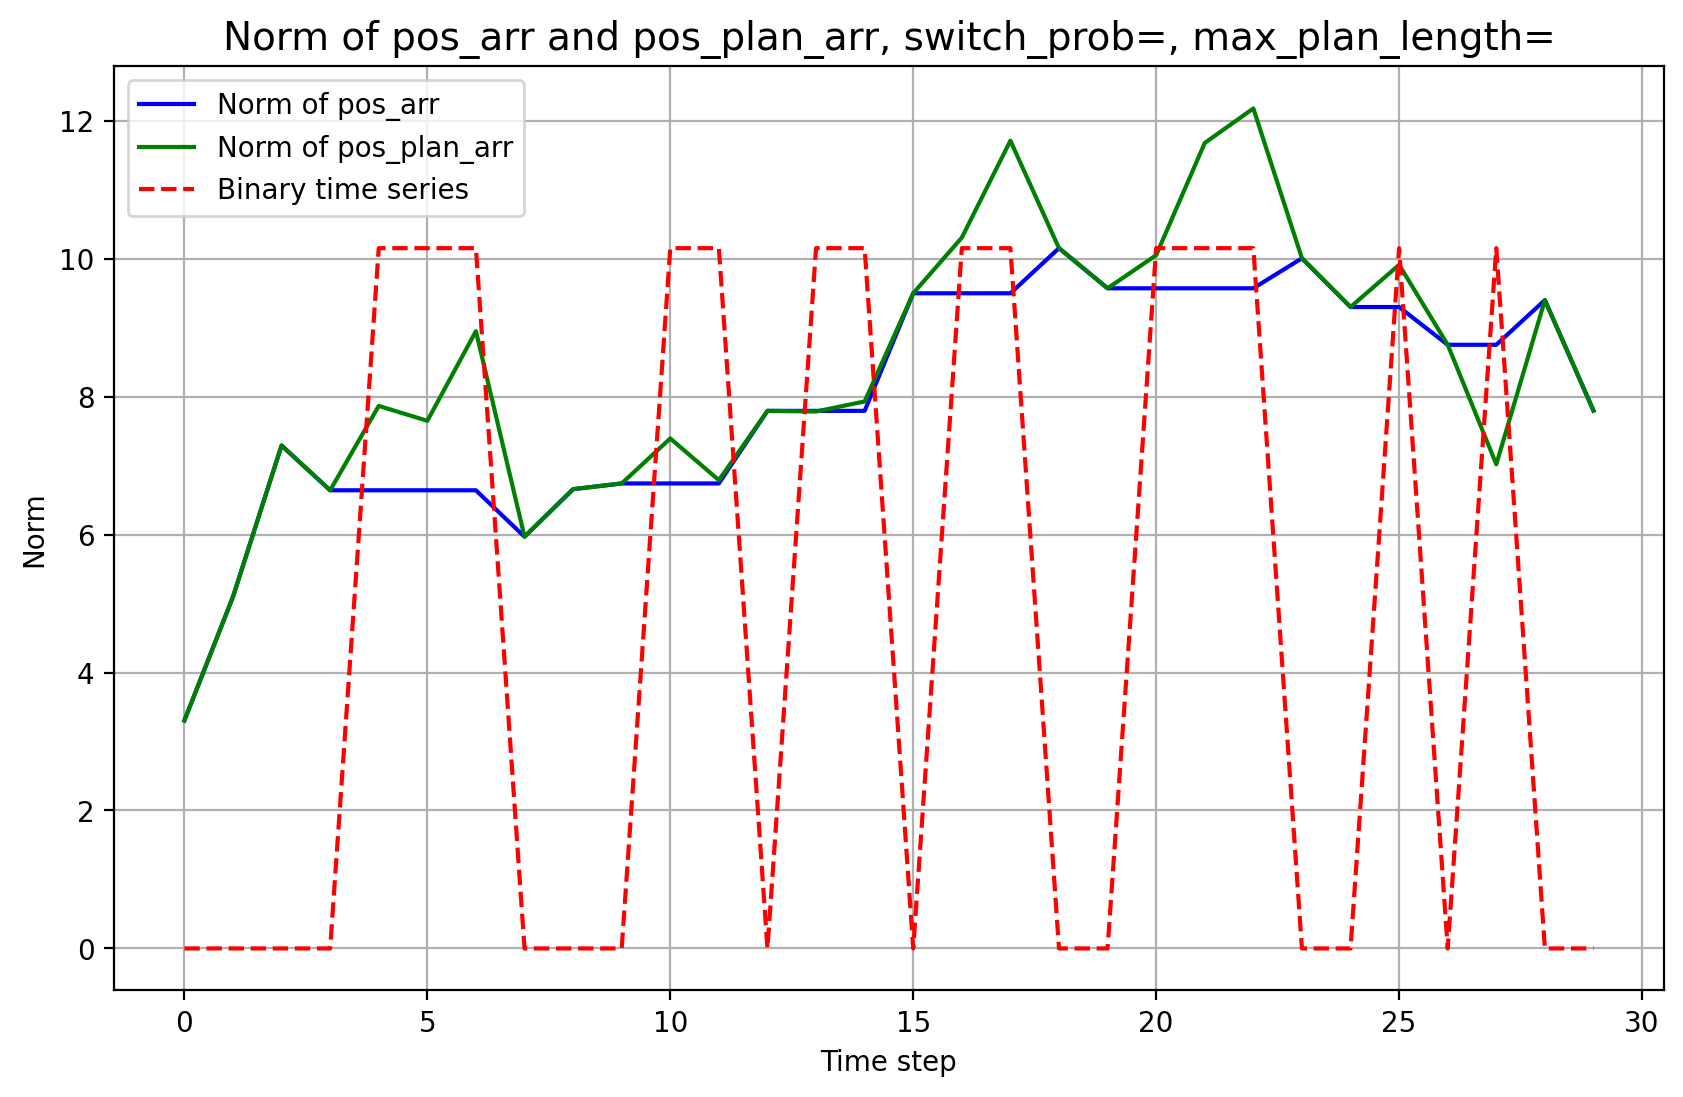

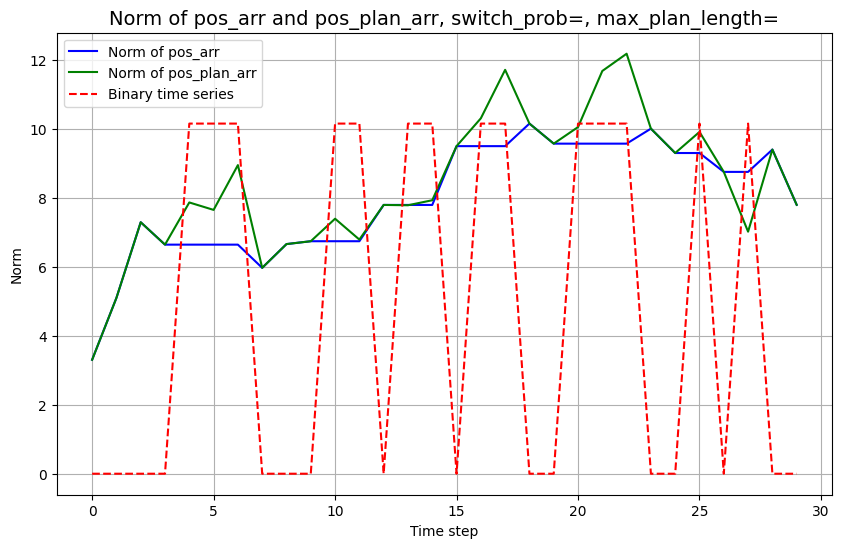

In [10]:
# plot timeseries, v7,8
%matplotlib inline

k = 5
binary_array = pm_arr[k,:,:].T # -1

# Calculate the norms
norm_pos_arr = jnp.linalg.norm(pos_arr[k,:,:].T, axis=1)
norm_pos_plan_arr = jnp.linalg.norm(pos_plan_arr[k,:,:].T, axis=1)

# Create the plot
plt.figure(figsize=(10, 6))

# Plotting norms
plt.plot(norm_pos_arr, label="Norm of pos_arr", color='blue')
plt.plot(norm_pos_plan_arr, label="Norm of pos_plan_arr", color='green')

# Plotting binary time series
plt.plot(binary_array[0,:] * norm_pos_arr.max(), label="Binary time series", color='red', linestyle='--')

# Additional plot settings
plt.title(f"Norm of pos_arr and pos_plan_arr, switch_prob={'0.2'}, max_plan_length={''}", fontsize=14)
plt.xlabel("Time step")
plt.ylabel("Norm")
plt.legend()
plt.grid(True)

plt.show()

In [11]:
# sort arrs, v7,10
# tot_loss = jnp.sum(loss_v_arr_+loss_d_arr_, axis=1)
# loss_tot_asc = jnp.argsort(tot_loss) #[::-1]
tot_loss_v = jnp.sum(loss_v_arr_, axis=1)
loss_v_asc = jnp.argsort(tot_loss_v) #[::-1]
loss_v_desc = jnp.argsort(tot_loss_v)[::-1]
# tot_loss_d = jnp.sum(loss_d_arr_, axis=1)
# loss_d_asc = jnp.argsort(tot_loss_d) #[::-1]
# print('loss_tot_asc=',loss_tot_asc[:10])
print('loss_v_asc=',loss_v_asc[:10])
print('loss_v_desc=',loss_v_desc[:10])
# print('loss_d_asc=',loss_d_asc[:10])

loss_v_asc= [145  90 138 392 455 328  52 349 296 147]
loss_v_desc= [355 292 373 383 156 249  79 453 327 262]


In [41]:
# full ani v7
%matplotlib qt
import numpy as np
import scipy
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.animation as animation
import functools
from matplotlib.patches import Ellipse


def mod_(x):
    return (x + np.pi) % (2 * np.pi) - np.pi

def gen_vectors(m, A): # modules/neurons, aperture
    x = np.linspace(-(A-A/m), (A-A/m), m)
    x_ = np.tile(x, (m, ))
    y_ = np.repeat(np.flip(x), m)
    return np.vstack([x_, y_])

def circ_mean_var(v_pred,vec_range):
    v_clamped = np.clip(v_pred,0,None)
    # get x/y coords
    x_y_coords = gen_vectors(np.int32(np.sqrt(len(v_clamped))),vec_range)
    x = x_y_coords[0,:]
    y = x_y_coords[1,:]
    # weighted complex numbers
    z_x = v_pred*(np.cos(x) + 1j*np.sin(x))
    z_y = v_pred*(np.cos(y) + 1j*np.sin(y))
    # mean
    mean_x = np.angle(np.sum(z_x)/np.sum(v_clamped))
    mean_y = np.angle(np.sum(z_y)/np.sum(v_clamped))
    # weighted circular variance for each angle
    circular_var_x = 1 - np.abs(np.sum(z_x) / np.sum(v_clamped))
    circular_var_y = 1 - np.abs(np.sum(z_y) / np.sum(v_clamped))
    circular_cov_matrix = np.diag([circular_var_x, circular_var_y])
    eigvals,eigvecs = np.linalg.eigh(circular_cov_matrix)
    sigma_x,sigma_y = np.sqrt(eigvals)  # no Scale factor for visualization
    return x_y_coords,x,y,mean_x,mean_y,sigma_x,sigma_y

def set_axis_properties(ax,lim,labels,title=''):
    ax.set_xlim(-lim,lim)
    ax.set_ylim(-lim,lim)
    ax.set_aspect('equal', 'box')  
    ax.set_title(title)
    ticks = np.linspace(-lim,lim,5)
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)

def get_aperture_points(agent_t,aperture,density):
    x_horizontal = np.linspace(agent_t[0] - aperture, agent_t[0] + aperture, density)
    y_top = np.full(density, agent_t[1] + aperture)
    y_bottom = np.full(density, agent_t[1] - aperture)
    y_vertical = np.linspace(agent_t[1] - aperture, agent_t[1] + aperture, density)
    x_left = np.full(density, agent_t[0] - aperture)
    x_right = np.full(density, agent_t[0] + aperture)
    x_tot = np.concatenate([x_left, x_right, x_horizontal, x_horizontal])
    y_tot = np.concatenate([y_vertical, y_vertical, y_bottom, y_top])
    return x_tot,y_tot

def is_point_in_ellipse(x,y,h,k,a,b):
    ellipse_eq = ((x - h)**2)/(a ** 2) + ((y - k)**2)/(b**2)
    return ellipse_eq <= 1

def vonmises_fit(x_coords,y_coords,v_pred_vec):
    # v_pred_vec = np.clip(v_pred_vec,0,None)
    # v_pred_norm = v_pred_vec/np.sum(v_pred_vec)
    scalar = 100
    kappa_max = 2
    integer_weights = np.int32(np.round(v_pred_vec*scalar))
    x_samples = np.repeat(x_coords, integer_weights)
    y_samples = np.repeat(y_coords, integer_weights)
    kappa_x,loc_x,_ = scipy.stats.vonmises.fit(x_samples)
    kappa_y,loc_y,_ = scipy.stats.vonmises.fit(y_samples)
    kappa_x = np.min([kappa_x,kappa_max])
    kappa_y = np.min([kappa_y,kappa_max])
    # mean_magnitude = (np.exp(kappa_x+kappa_y)/((2*np.pi)**2 * scipy.special.i0(kappa_x) * scipy.special.i0(kappa_y)))
    log_numerator = kappa_x + kappa_y
    log_denominator = 2 * np.log(2*np.pi) + np.log(scipy.special.i0(kappa_x)) + np.log(scipy.special.i0(kappa_y))
    log_result = log_numerator - log_denominator
    mean_magnitude = np.exp(log_result)
    return kappa_x,loc_x,kappa_y,loc_y,mean_magnitude

def animate(i,v_pred_arr,v_t_arr,dot_arr,pos_plan_arr,pos_arr,dot,agent_plan,agent,neuron_locs,scatters_pred,scatters_t,aperture_points_plan,aperture_points,aperture_points_v_pred,aperture_points_v_t,act_space_points_plan,act_space_points,ell_circular,ell_circular_v_pred,ell_circular_v_t,in_ell_array,L):
    dot.set_data(mod_(dot_arr[i, 0]), mod_(dot_arr[i, 1]))
    agent_plan.set_data(mod_(pos_plan_arr[i, 0]), mod_(pos_plan_arr[i, 1]))
    agent.set_data(mod_(pos_arr[i, 0]), mod_(pos_arr[i, 1]))
    # dot_hat.set_data(mod_(dot_hat_arr[i, 0]), mod_(dot_hat_arr[i, 1]))

    if i == 0:
        aperture_points.set_color('green')
        L.get_texts()[0].set_text(f'Frame={i}, Reward=')
    else:
        aperture_points.set_color('black')

    x_y_coords,x,y,mean_x,mean_y,sigma_x,sigma_y = circ_mean_var(v_pred_arr[i],np.pi)### think
    # x_y_coords,x,y,mean_x_ap,mean_y_ap,sigma_x_ap,sigma_y_ap = circ_mean_var(v_pred_arr[i],np.pi)### think
    ell_circular.set_center((mod_(mean_x+pos_plan_arr[i, 0]), mod_(mean_y+pos_plan_arr[i, 1])))
    ell_circular.width = SIGMA_SCALE*sigma_x
    ell_circular.height = SIGMA_SCALE*sigma_y
    ell_circular_v_pred.set_center((mean_x, mean_y))
    ell_circular_v_pred.width = SIGMA_SCALE*sigma_x
    ell_circular_v_pred.height = SIGMA_SCALE*sigma_y
    ell_circular_v_t.set_center((mean_x, mean_y))
    ell_circular_v_t.width = SIGMA_SCALE*sigma_x
    ell_circular_v_t.height = SIGMA_SCALE*sigma_y
    if i>0:
        in_ell_array[i] = is_point_in_ellipse(mod_(mean_x+pos_plan_arr[i, 0]), mod_(mean_y+pos_plan_arr[i, 1]), mod_(dot_arr[i,0]), mod_(dot_arr[i,1]), SIGMA_SCALE*sigma_x, SIGMA_SCALE*sigma_y)
        kappa_x,loc_x,kappa_y,loc_y,mean_magnitude = vonmises_fit(x_y_coords[0,:],x_y_coords[1,:],v_pred_arr[i])
        lab = f'Frame={i}, Reward={mean_magnitude:.3f}' #, k={kappa_x:.3f},{kappa_y:.3f}'
        L.get_texts()[0].set_text(lab)

    scatters_pred.set_offsets(neuron_locs.T)
    scatters_pred.set_array(v_pred_arr[i])
    scatters_pred.set_sizes(15 * np.sqrt(v_pred_arr[i])) # []
    scatters_pred.set_facecolors('k')

    scatters_t.set_offsets(neuron_locs.T)
    scatters_t.set_array(v_t_arr[i])
    scatters_t.set_sizes(15 * np.sqrt(v_t_arr[i])) # []
    scatters_t.set_facecolors('k')
    x_aperture_plan,y_aperture_plan = get_aperture_points(pos_plan_arr[i],APERTURE,DENSITY_DEFAULT)
    aperture_points_plan.set_offsets(np.c_[mod_(x_aperture_plan), mod_(y_aperture_plan)])
    x_aperture,y_aperture = get_aperture_points(pos_arr[i],APERTURE,DENSITY_DEFAULT)
    aperture_points.set_offsets(np.c_[mod_(x_aperture), mod_(y_aperture)])
    x_aperture_centre,y_aperture_centre = get_aperture_points(np.array([0,0]),APERTURE,DENSITY_DEFAULT)
    aperture_points_v_pred.set_offsets(np.c_[mod_(x_aperture_centre), mod_(y_aperture_centre)])
    aperture_points_v_t.set_offsets(np.c_[mod_(x_aperture_centre), mod_(y_aperture_centre)])
    x_act_space_plan,y_act_space_plan = get_aperture_points(pos_plan_arr[i],ACTION_SPACE,DENSITY_ACT_PLAN)
    act_space_points_plan.set_offsets(np.c_[mod_(x_act_space_plan), mod_(y_act_space_plan)])
    x_act_space,y_act_space = get_aperture_points(pos_arr[i],ACTION_SPACE,DENSITY_ACT_PLAN)
    act_space_points.set_offsets(np.c_[mod_(x_act_space), mod_(y_act_space)])

    # x_plan_space,y_plan_space = get_aperture_points(pos_arr[i],PLAN_SPACE,DENSITY_PLAN_SPACE)
    # plan_space_points.set_offsets(np.c_[mod_(x_plan_space), mod_(y_plan_space)])
    
    return [dot,agent_plan,agent,scatters_pred,scatters_t,aperture_points_plan,aperture_points,aperture_points_v_pred,aperture_points_v_t,act_space_points_plan,act_space_points,ell_circular,ell_circular_v_pred,ell_circular_v_t,L]

k = 325 # 7,1,25 # 473 # 63 # 10 # 380 # 238,470 # 0_i,313,216,188_d,
interval = 300
APERTURE = (1/2)*np.pi # (3/5)*np.pi # (1/2)*np.pi # (np.sqrt(2)/2)*np.pi # np.pi/2
ACTION_FRAC = 1 # 1/2
ACTION_SPACE = ACTION_FRAC*APERTURE # np.pi/4
PLAN_FRAC_REL = 1 #2 3/2 # 3/2
PLAN_SPACE = PLAN_FRAC_REL*ACTION_SPACE # np.pi/2
STEPS = v_pred_arr.shape[1]
MODULES = 7 # 7 # 9 # 17 # 15
NEURONS_DISP = np.int32(np.sqrt(v_pred_arr.shape[2])) ##14 # 16 # 15 # 15 # 12 # 6 # ''full'' np.int32(NEURONS_AP*(np.pi//APERTURE))
SIGMA_SCALE = 3

DENSITY_DEFAULT = 1000
DENSITY_ACT_PLAN = 15

neuron_locs = gen_vectors(NEURONS_DISP,jnp.pi) # NEURONS
v_pred_arr_ = np.clip(v_pred_arr[k,:,:],0,1)
v_t_arr_ = v_t_arr[k,:,:]
dot_arr_ = dot_arr[k,:,:].T # [STEPS,2]
pos_arr_ = pos_arr[k,:,:].T # [STEPS,2]
pos_plan_arr_ = pos_plan_arr[k,:,:].T # [STEPS,2]
pm_arr_ = pm_arr[k,:,:] # [STEPS,2]
# dot_hat_arr_ = mod_(rel_vec_hat_arr_ + pos_arr_)

fig = plt.figure(figsize=(8, 12))
gs = gridspec.GridSpec(3, 2, height_ratios=[1, 1, 1])

ax_ani = plt.subplot(gs[0:2, 0:2],aspect='equal')
set_axis_properties(ax_ani,jnp.pi,["$-\pi$", "$-\pi/2$", "0", "$\pi/2$", "$\pi$"])
agent_plan, = ax_ani.plot(mod_(pos_plan_arr_[0, 0]), mod_(pos_plan_arr_[0, 1]), color='lightgrey', marker='+', markersize=12) #, label='agent')
agent, = ax_ani.plot(mod_(pos_arr_[0, 0]), mod_(pos_arr_[0, 1]), 'k+', markersize=12) #, label='agent')
dot, = ax_ani.plot(mod_(dot_arr_[0, 0]), mod_(dot_arr_[0, 1]), 'rx', markersize=10) #, label='dot')
text_ani, = ax_ani.plot([], [], '', label=f'Frame=0, Reward=')
# dot_hat, = ax_ani.plot(mod_(dot_hat_arr_[0, 0]), mod_(dot_hat_arr_[0, 1]), 'bx', markersize=10, label='dot_hat')

aperture_points = ax_ani.scatter([], [], color='black', s=1)
aperture_points_plan = ax_ani.scatter([], [], color='lightgrey', s=1)
act_space_points = ax_ani.scatter([], [], color='black', s=1)
act_space_points_plan = ax_ani.scatter([], [], color='lightgrey', s=1)
# plan_space_points = ax_ani.scatter([], [], color='lightgrey', s=1)

ell_circular = Ellipse(xy=(0, 0), width=1, height=1, edgecolor='blue', facecolor='none')
ell_circular_patch = ax_ani.add_patch(ell_circular)
# text_ani = ax_ani.text(0.5, 0.8, '', transform=ax_ani.transAxes)
# ax_ani.legend(loc='upper left', bbox_to_anchor=(1, 1))
# ax_ani.legend(loc='upper right')
L=ax_ani.legend(loc='upper right')

in_ell_array = np.zeros(STEPS,)

ax_pred = plt.subplot(gs[2, 0], aspect='equal')
# update scatter
scatters_pred = ax_pred.scatter(
    neuron_locs[0, :], neuron_locs[1, :], 
    c='k', # v_pred_arr_[0], 
    s=15 * np.sqrt(v_pred_arr_[0]), 
    marker='o',
    vmin=0, vmax=1)
aperture_points_v_pred = ax_pred.scatter([], [], color='black', s=0.5)
ell_circular_v_pred = Ellipse(xy=(0, 0), width=1, height=1, edgecolor='blue', facecolor='none')
ecp_v_pred = ax_pred.add_patch(ell_circular_v_pred)
set_axis_properties(ax_pred, jnp.pi, ["$-\pi$", "$-\pi/2$", "0", "$\pi/2$", "$\pi$"], 'v_pred')

ax_t = plt.subplot(gs[2, 1], aspect='equal')
# update scatter
scatters_t = ax_t.scatter(
    neuron_locs[0, :], neuron_locs[1, :], 
    c='k', # v_t_arr_[0], 
    s=15 * np.sqrt(v_t_arr_[0]), 
    marker='o',
    vmin=0, vmax=1)  # Assuming activations range from 0 to 1
aperture_points_v_t = ax_t.scatter([], [], color='black', s=0.5)
ell_circular_v_t = Ellipse(xy=(0, 0), width=1, height=1, edgecolor='blue', facecolor='none')
ecp_v_t = ax_t.add_patch(ell_circular_v_t)
set_axis_properties(ax_t, jnp.pi, ["$-\pi$", "$-\pi/2$", "0", "$\pi/2$", "$\pi$"], 'v_t')

partial_animate = functools.partial(
    animate,
    v_pred_arr=v_pred_arr_, 
    v_t_arr=v_t_arr_, 
    dot_arr=dot_arr_, 
    # dot_hat_arr=dot_hat_arr_,
    pos_plan_arr=pos_plan_arr_,
    pos_arr=pos_arr_, 
    dot=dot, 
    # dot_hat=dot_hat,
    agent_plan=agent_plan,
    agent=agent, 
    neuron_locs=neuron_locs, 
    scatters_pred=scatters_pred, 
    scatters_t=scatters_t,
    aperture_points_plan=aperture_points_plan,
    aperture_points=aperture_points,
    aperture_points_v_pred=aperture_points_v_pred,
    aperture_points_v_t=aperture_points_v_t,
    act_space_points_plan=act_space_points_plan,
    act_space_points=act_space_points,
    # plan_space_points=plan_space_points,
    ell_circular=ell_circular,
    ell_circular_v_pred=ell_circular_v_pred,
    ell_circular_v_t=ell_circular_v_t,
    in_ell_array=in_ell_array,
    # text_ani=text_ani,
    # ax_ani=ax_ani,
    L=L,
    )

ani = animation.FuncAnimation(
    fig=fig, 
    func=partial_animate,
    frames=STEPS, 
    blit=True, 
    interval=interval
    )

plt.tight_layout()
plt.show()

print('in_ell_array=',in_ell_array[1:])
print(r'% in array = ',np.sum(in_ell_array[1:])/(STEPS-1))

in_ell_array= [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
% in array =  0.0


/var/folders/hp/sdqbmwnd5m14lcp1k2qjnkx00000gn/T/ipykernel_33770/1257284445.py:193: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  scatters_pred = ax_pred.scatter(
/var/folders/hp/sdqbmwnd5m14lcp1k2qjnkx00000gn/T/ipykernel_33770/1257284445.py:206: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  scatters_t = ax_t.scatter(
/var/folders/hp/sdqbmwnd5m14lcp1k2qjnkx00000gn/T/ipykernel_33770/1257284445.py:87: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  dot.set_data(mod_(dot_arr[i, 0]), mod_(dot_arr[i, 1]))
/var/folders/hp/sdqbmwnd5m14lcp1k2qjnkx00000gn/T/ipykernel_33770/1257284445.py:88: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  agent_plan.set_data(mod_(pos_plan_arr[i, 0]), mod_(pos_plan_arr[i, 1]))
/va

Average moving losses: [0.41792929 0.30322155 0.26725057 0.21413462 0.2032183  0.17641304 0.16297062 0.16961011 0.15996377 0.15514608 0.14393981 0.13734256 0.1510694  0.15735108 0.13042845 0.1087459  0.07604434 0.16732758
 0.05662816 0.22601442 0.06703505 0.11838413]
Std moving losses: [0.36305133 0.33617213 0.30712569 0.25245306 0.26414296 0.18435128 0.18478385 0.19258371 0.14875518 0.116111   0.0753721  0.07795125 0.18561032 0.17129147 0.09453005 0.05917021 0.03617016 0.13200822
 0.00145539 0.         0.         0.        ]
Average planning losses: [0.27687693 0.32652673 0.38839567]
Std planning losses: [0.32485619 0.34510642 0.35889396]


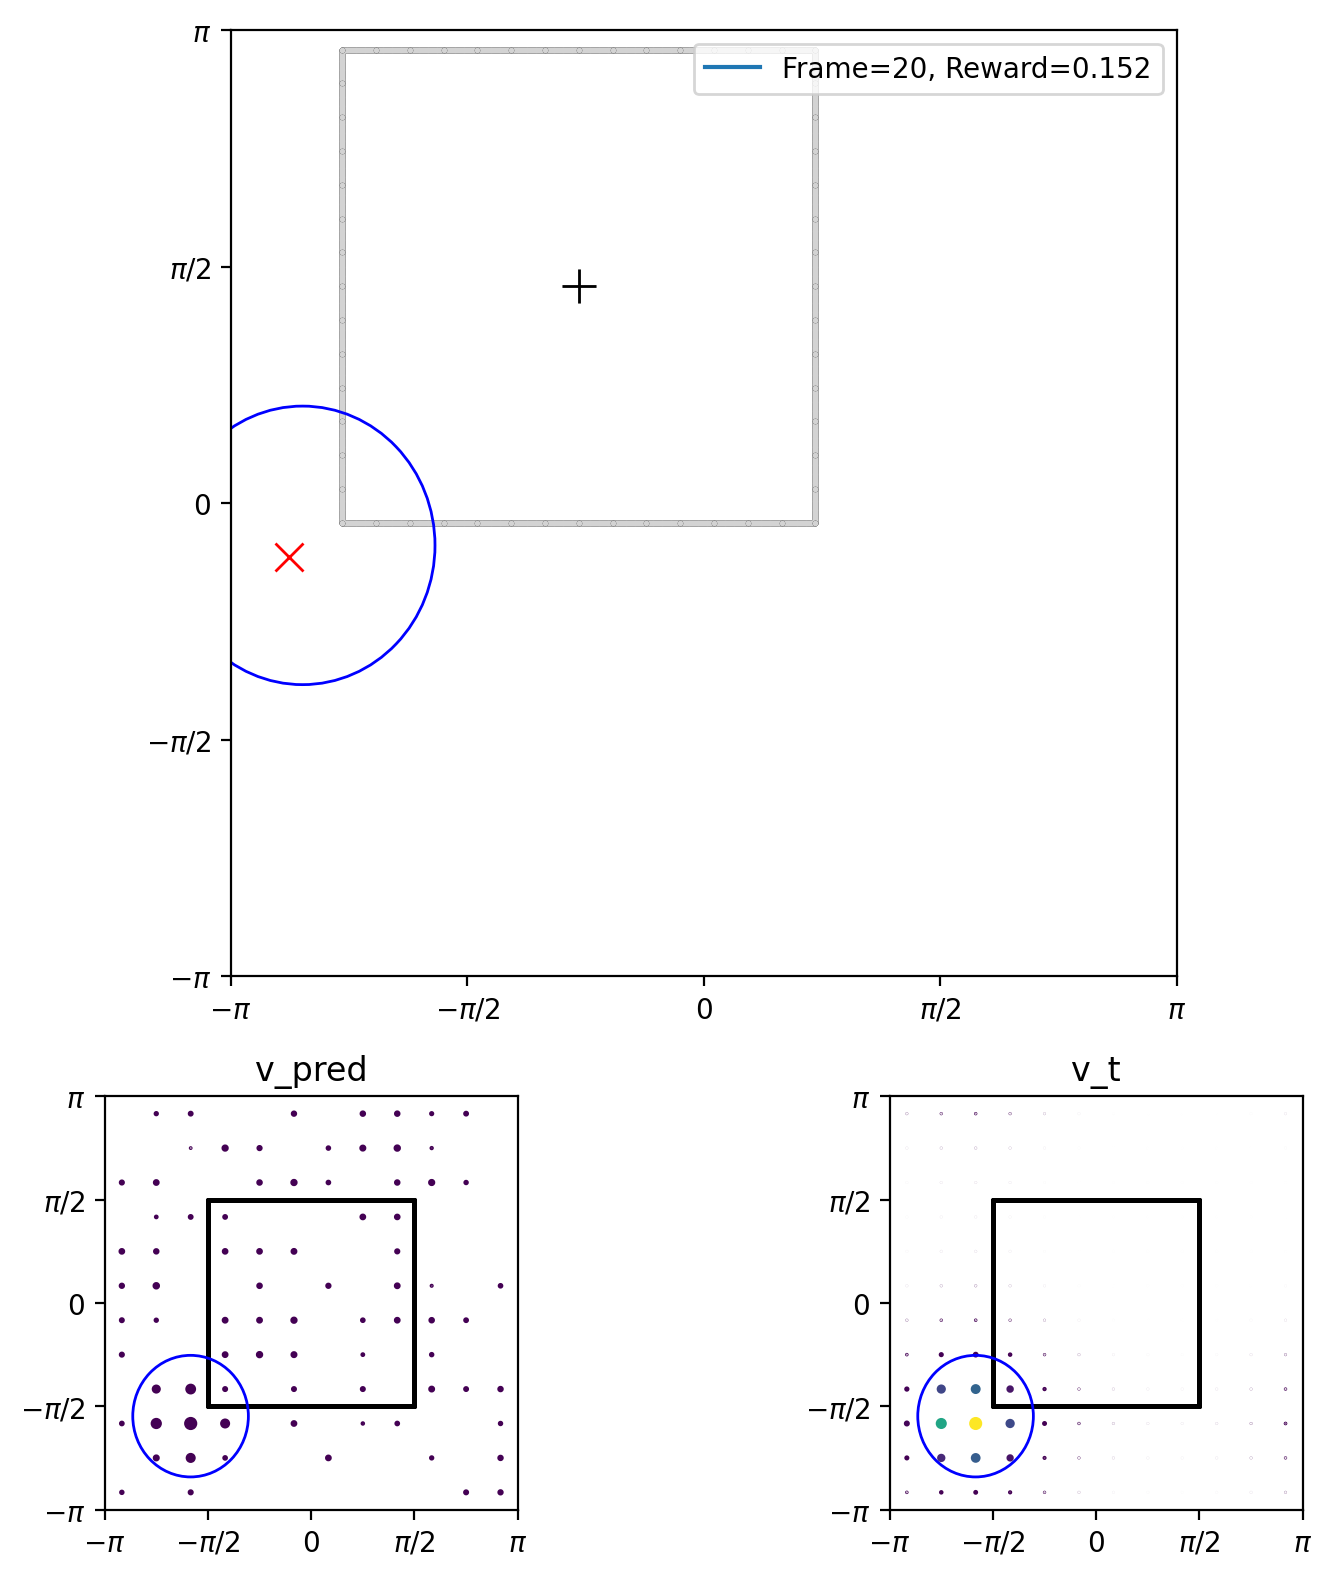

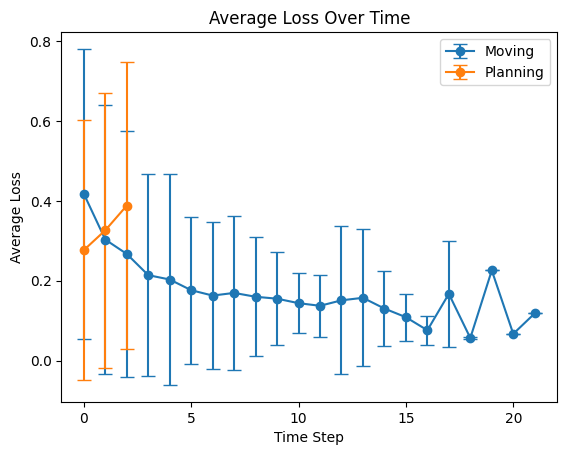

In [18]:
# plot loss vs t for moving/planning

%matplotlib inline

def analyze_losses(losses, binary_flags):
    N, L = losses.shape  # N is the number of trials, L is the length of the timeseries
    
    # Initialize lists to collect moving and planning losses
    moving_losses = []
    planning_losses = []
    
    # Iterate over trials
    for i in range(N):
        flag_series = binary_flags[i, :]
        loss_series = losses[i, :]
        
        moving_count = 0
        planning_count = 0
        start = True
        
        # Collect losses for current trial
        moving_losses_trial = []
        planning_losses_trial = []
        
        for j in range(L):
            if start and flag_series[j] == 0:
                continue  # Disregard the first 'movement' period
            else:
                start = False
            
            if flag_series[j] == 0:  # Moving
                moving_losses_trial.append((moving_count, loss_series[j]))
                moving_count += 1
                planning_count = 0
            else:  # Planning
                planning_losses_trial.append((planning_count, loss_series[j]))
                planning_count += 1
                moving_count = 0
                
        moving_losses.extend(moving_losses_trial)
        planning_losses.extend(planning_losses_trial)

    # Group by time steps and compute mean and std
    def group_and_analyze(grouped_data):
        max_steps = max(x[0] for x in grouped_data) + 1
        avg_losses = np.zeros(max_steps)
        std_losses = np.zeros(max_steps)
        
        for step in range(max_steps):
            step_losses = [x[1] for x in grouped_data if x[0] == step]
            if len(step_losses) > 0:
                avg_losses[step] = np.mean(step_losses)
                std_losses[step] = np.std(step_losses)
                
        return avg_losses, std_losses
    
    avg_moving_losses, std_moving_losses = group_and_analyze(moving_losses)
    avg_planning_losses, std_planning_losses = group_and_analyze(planning_losses)
    
    return avg_moving_losses, std_moving_losses, avg_planning_losses, std_planning_losses

# Create example data
# N = 10  # Number of trials
# L = 100  # Length of timeseries
# losses = np.random.rand(N, L)
# binary_flags = np.random.randint(2, size=(N, L))

avg_moving_losses, std_moving_losses, avg_planning_losses, std_planning_losses = analyze_losses(loss_v_arr_, pm_arr[:,:,0])

print("Average moving losses:", avg_moving_losses)
print("Std moving losses:", std_moving_losses)
print("Average planning losses:", avg_planning_losses)
print("Std planning losses:", std_planning_losses)

# Create the plot
fig, ax = plt.subplots()

# Plot average moving losses
ax.errorbar(range(len(avg_moving_losses)), avg_moving_losses, yerr=std_moving_losses, fmt='-o', label='Moving', capsize=5)

# Plot average planning losses
ax.errorbar(range(len(avg_planning_losses)), avg_planning_losses, yerr=std_planning_losses, fmt='-o', label='Planning', capsize=5)

# Add titles and labels
ax.set_title('Average Loss Over Time')
ax.set_xlabel('Time Step')
ax.set_ylabel('Average Loss')

# Add a legend
ax.legend()

# Show the plot
plt.show()

In [26]:
# load arrs, v2/3 (scalar)
import jax
import jax.numpy as jnp
from jax import jit
import jax.random as rnd
import numpy as np
np.set_printoptions(threshold=1000, linewidth=200)
import matplotlib
matplotlib.use('Qt5Agg')
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
import matplotlib.cm as cm
from matplotlib.patches import Ellipse
import os
import functools

def load_data(str_):
    path_ = os.path.dirname(os.getcwd()) + '/sc_project/test_data/' # Path(__file__).resolve().parents[1]
    with open(path_+str_,'rb') as file_:
        # param = pickle.load(file_)
        param_ = jnp.load(file_,allow_pickle=True)
    return param_

file_ = 'forward_new_v6_81M_144N_24_08-113913.pkl' # 'forward_new_v7_81M_144N_30_08-025022.pkl' 
# 'forward_new_v6_81M_144N_24_08-113913.pkl' # 'forward_new_v6_81M_144N_23_08-003120.pkl' # 'forward_new_v6_81M_144N_22_08-082725.pkl' # 'forward_new_v6_49M_196N_21_08-114445.pkl' # 'forward_new_v6_81M_144N_20_08-221656.pkl' # 'forward_new_v6_49M_144N_20_08-141141.pkl' # 'forward_new_v6_49M_196N_20_08-062204.pkl' # 'forward_new_v6_49M_144N_20_08-034844.pkl' # 'forward_new_v6_49M_225N_19_08-074624.pkl' # 'forward_new_v6_49M_144N_19_08-152345.pkl' # 'forward_new_v6_49M_225N_19_08-074624.pkl' # 'forward_new_v7_49M_144N_18_08-201455.pkl' # 'forward_new_v7_49M_400N_18_08-135311.pkl' # 'forward_new_v7_49M_100N_18_08-130109.pkl' # 'forward_new_v2_225_03_08-1113.pkl'##'forward_new_v5_49M_400N_14_08-194748.pkl' # 'forward_new_v5_49M_400N_14_08-193709.pkl' # 'forward_new_v4_49_11_08-142011.pkl' # 'forward_new_v4_49M_400N_11_08-140804.pkl' # 'forward_new_v4_49_11_08-131157.pkl' # 'forward_new_v4_49_11_08-112201.pkl' # 'forward_new_v4_49_11_08-0438.pkl' # 'forward_new_v3_49_10_08-1729.pkl' # 'forward_new_v3_49_10_08-1736.pkl' # 'forward_new_v3_81_10_08-1412.pkl' # 'forward_new_v3_81_10_08-0255.pkl' # 'forward_new_v3_81_09_08-2022.pkl' # 'forward_new_v3_289_09_08-1618.pkl' # 'forward_new_v2_225_03_08-1113.pkl' # 
(arrs,aux) = load_data(file_) # # [VMAPS,STEPS,N]x2,[VMAPS,STEPS,2]x3,[VMAPS,STEPS]x2
(loss_arr,loss_sem,loss_v_arr,v_std_arr,loss_r_arr,r_std_arr) = arrs
(v_pred_arr,v_t_arr,loss_v_arr_,loss_d_arr_,pos_arr,dot_arr,rel_vec_hat_arr,opt_state,p_weights) = aux
print('loss_arr.shape=',loss_arr.shape,'loss_sem.shape=',loss_sem.shape,'loss_v_arr.shape=',loss_v_arr.shape,'v_std_arr.shape=',v_std_arr.shape,'loss_r_arr.shape=',loss_r_arr.shape,'r_std_arr.shape=',r_std_arr.shape)
print('v_pred_arr.shape=',v_pred_arr.shape,'v_t_arr.shape=',v_t_arr.shape,'loss_v_arr_.shape=',loss_v_arr_.shape,'loss_d_arr_.shape=',loss_d_arr_.shape,'pos_arr.shape=',pos_arr.shape,'dot_arr.shape=',dot_arr.shape,'rel_vec_hat_arr.shape=',rel_vec_hat_arr.shape)
# rel_vec_hat_arr = jnp.concatenate([jnp.nan*jnp.zeros((500,1,2)),rel_vec_hat_arr],axis=1)
# dot_arr = dot_arr[:,:,:-1]

loss_arr.shape= (50000,) loss_sem.shape= (50000,) loss_v_arr.shape= (50000, 30) v_std_arr.shape= (50000, 30) loss_r_arr.shape= (50000, 30) r_std_arr.shape= (50000, 30)
v_pred_arr.shape= (500, 30, 144) v_t_arr.shape= (500, 30, 144) loss_v_arr_.shape= (500, 30) loss_d_arr_.shape= (500, 30) pos_arr.shape= (500, 2, 30) dot_arr.shape= (500, 2, 30) rel_vec_hat_arr.shape= (500, 30, 2)


In [68]:
# sort arrs, v2/3
tot_loss = jnp.sum(loss_v_arr_+loss_d_arr_, axis=1)
loss_tot_asc = jnp.argsort(tot_loss) #[::-1]
tot_loss_v = jnp.sum(loss_v_arr_, axis=1)
loss_v_asc = jnp.argsort(tot_loss_v) #[::-1]
loss_v_desc = jnp.argsort(tot_loss_v)[::-1]
tot_loss_d = jnp.sum(loss_d_arr_, axis=1)
loss_d_asc = jnp.argsort(tot_loss_d) #[::-1]
print('loss_tot_asc=',loss_tot_asc[:10])
print('loss_v_asc=',loss_v_asc[:10])
print('loss_v_desc=',loss_v_desc[:10])
print('loss_d_asc=',loss_d_asc[:10])

loss_tot_asc= [  6  52 386 262 397 316 129 402 364 453]
loss_v_asc= [316   6 364 234 453 105 129  52 472 402]
loss_v_desc= [442 138 249 324  53 140 139 163 371 468]
loss_d_asc= [442 249 140  21 163 138 468  53 437  60]


In [86]:
# full ani v3 wip
%matplotlib qt
import numpy as np
import scipy
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.animation as animation
import functools
from matplotlib.patches import Ellipse

def mod_(x):
    return (x + np.pi) % (2 * np.pi) - np.pi

def gen_vectors(m, A): # modules/neurons, aperture
    x = np.linspace(-(A-A/m), (A-A/m), m)
    x_ = np.tile(x, (m, ))
    y_ = np.repeat(np.flip(x), m)
    return np.vstack([x_, y_])

def circ_mean_var(v_pred,vec_range):
    v_clamped = np.clip(v_pred,0,None)
    # get x/y coords
    x_y_coords = gen_vectors(np.int32(np.sqrt(len(v_clamped))),vec_range)
    x = x_y_coords[0,:]
    y = x_y_coords[1,:]
    # weighted complex numbers
    z_x = v_pred*(np.cos(x) + 1j*np.sin(x))
    z_y = v_pred*(np.cos(y) + 1j*np.sin(y))
    # mean
    mean_x = np.angle(np.sum(z_x)/np.sum(v_clamped))
    mean_y = np.angle(np.sum(z_y)/np.sum(v_clamped))
    # weighted circular variance for each angle
    circular_var_x = 1 - np.abs(np.sum(z_x) / np.sum(v_clamped))
    circular_var_y = 1 - np.abs(np.sum(z_y) / np.sum(v_clamped))
    circular_cov_matrix = np.diag([circular_var_x, circular_var_y])
    eigvals,eigvecs = np.linalg.eigh(circular_cov_matrix)
    sigma_x,sigma_y = np.sqrt(eigvals)  # no Scale factor for visualization
    return x_y_coords,x,y,mean_x,mean_y,sigma_x,sigma_y

def set_axis_properties(ax,lim,labels,title=''):
    ax.set_xlim(-lim,lim)
    ax.set_ylim(-lim,lim)
    ax.set_aspect('equal', 'box')  
    ax.set_title(title)
    ticks = np.linspace(-lim,lim,5)
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)

def get_aperture_points(agent_t,aperture,density):
    x_horizontal = np.linspace(agent_t[0] - aperture, agent_t[0] + aperture, density)
    y_top = np.full(density, agent_t[1] + aperture)
    y_bottom = np.full(density, agent_t[1] - aperture)
    y_vertical = np.linspace(agent_t[1] - aperture, agent_t[1] + aperture, density)
    x_left = np.full(density, agent_t[0] - aperture)
    x_right = np.full(density, agent_t[0] + aperture)
    x_tot = np.concatenate([x_left, x_right, x_horizontal, x_horizontal])
    y_tot = np.concatenate([y_vertical, y_vertical, y_bottom, y_top])
    return x_tot,y_tot

def is_point_in_ellipse(x,y,h,k,a,b):
    ellipse_eq = ((x - h)**2)/(a ** 2) + ((y - k)**2)/(b**2)
    return ellipse_eq <= 1

def vonmises_fit(x_coords,y_coords,v_pred_vec):
    # v_pred_vec = np.clip(v_pred_vec,0,None)
    # v_pred_norm = v_pred_vec/np.sum(v_pred_vec)
    scalar = 100
    kappa_max = 2
    integer_weights = np.int32(np.round(v_pred_vec*scalar))
    x_samples = np.repeat(x_coords, integer_weights)
    y_samples = np.repeat(y_coords, integer_weights)
    kappa_x,loc_x,_ = scipy.stats.vonmises.fit(x_samples)
    kappa_y,loc_y,_ = scipy.stats.vonmises.fit(y_samples)
    kappa_x = np.min([kappa_x,kappa_max])
    kappa_y = np.min([kappa_y,kappa_max])
    # mean_magnitude = (np.exp(kappa_x+kappa_y)/((2*np.pi)**2 * scipy.special.i0(kappa_x) * scipy.special.i0(kappa_y)))
    log_numerator = kappa_x + kappa_y
    log_denominator = 2 * np.log(2*np.pi) + np.log(scipy.special.i0(kappa_x)) + np.log(scipy.special.i0(kappa_y))
    log_result = log_numerator - log_denominator
    mean_magnitude = np.exp(log_result)
    return kappa_x,loc_x,kappa_y,loc_y,mean_magnitude

def animate(i,v_pred_arr,v_t_arr,dot_arr,pos_arr,dot,agent,neuron_locs,scatters_pred,scatters_t,aperture_points,aperture_points_v_pred,aperture_points_v_t,act_space_points,plan_space_points,ell_circular,ell_circular_v_pred,ell_circular_v_t,in_ell_array,L,text_ani):
    dot.set_data(mod_(dot_arr[i, 0]), mod_(dot_arr[i, 1]))
    agent.set_data(mod_(pos_arr[i, 0]), mod_(pos_arr[i, 1]))
    # dot_hat.set_data(mod_(dot_hat_arr[i, 0]), mod_(dot_hat_arr[i, 1]))

    if i == 0:
        aperture_points.set_color('green')
    else:
        aperture_points.set_color('black')

    x_y_coords,x,y,mean_x,mean_y,sigma_x,sigma_y = circ_mean_var(v_pred_arr[i],np.pi)### think
    # x_y_coords,x,y,mean_x_ap,mean_y_ap,sigma_x_ap,sigma_y_ap = circ_mean_var(v_pred_arr[i],np.pi)### think
    # scale = APERTURE/jnp.pi
    ell_circular.set_center((mod_(mean_x+pos_arr[i, 0]), mod_(mean_y+pos_arr[i, 1])))
    ell_circular.width = SIGMA_SCALE*sigma_x
    ell_circular.height = SIGMA_SCALE*sigma_y
    ell_circular_v_pred.set_center((mean_x, mean_y))
    ell_circular_v_pred.width = SIGMA_SCALE*sigma_x
    ell_circular_v_pred.height = SIGMA_SCALE*sigma_y
    ell_circular_v_t.set_center((mean_x, mean_y))
    ell_circular_v_t.width = SIGMA_SCALE*sigma_x
    ell_circular_v_t.height = SIGMA_SCALE*sigma_y
    if i>0:
        in_ell_array[i] = is_point_in_ellipse(mod_(mean_x+pos_arr[i, 0]), mod_(mean_y+pos_arr[i, 1]), mod_(dot_arr[i,0]), mod_(dot_arr[i,1]), SIGMA_SCALE*sigma_x, SIGMA_SCALE*sigma_y)
        kappa_x,loc_x,kappa_y,loc_y,mean_magnitude = vonmises_fit(x_y_coords[0,:],x_y_coords[1,:],v_pred_arr[i])
        # text_ani.set_label(f'Frame {i}/{STEPS}, reward={mean_magnitude:.3f}')    
        # ax_ani.get_legend().remove()
        # ax_ani.legend(loc='right') #, bbox_to_anchor=(1, 1))
        # text_ani.set_text(f'vm_fit_mean={mean_magnitude}') # mod_(loc_x+pos_arr[i, 0])},{mod_(loc_y+pos_arr[i, 1])
        # print('i=',i,'mean_ell=',mod_(mean_x+pos_arr[i, 0]),mod_(mean_y+pos_arr[i, 1]),'mean_vm=',mod_(loc_x+pos_arr[i, 0]),mod_(loc_y+pos_arr[i, 1]),'mean_magnitude_vm=',mean_magnitude)
        lab = f'Frame={i}, Reward={mean_magnitude:.3f}' #, k={kappa_x:.3f},{kappa_y:.3f}'
        L.get_texts()[0].set_text(lab)

    # print('pos=',pos_arr[i,:],'mean=',mean_x,mean_y,'sigma=',sigma_x,sigma_y,'in_ell=',in_ell_array[i])

    scatters_pred.set_offsets(neuron_locs.T)
    scatters_pred.set_array(v_pred_arr[i])
    scatters_pred.set_sizes(15 * np.sqrt(v_pred_arr[i])) # []
    scatters_pred.set_facecolors('k')

    scatters_t.set_offsets(neuron_locs.T)
    scatters_t.set_array(v_t_arr[i])
    scatters_t.set_sizes(15 * np.sqrt(v_t_arr[i])) # []
    scatters_t.set_facecolors('k')
    x_aperture,y_aperture = get_aperture_points(pos_arr[i],APERTURE,DENSITY_DEFAULT)
    x_aperture_centre,y_aperture_centre = get_aperture_points(np.array([0,0]),APERTURE,DENSITY_DEFAULT)
    aperture_points.set_offsets(np.c_[mod_(x_aperture), mod_(y_aperture)])
    aperture_points_v_pred.set_offsets(np.c_[mod_(x_aperture_centre), mod_(y_aperture_centre)])
    aperture_points_v_t.set_offsets(np.c_[mod_(x_aperture_centre), mod_(y_aperture_centre)])
    x_act_space,y_act_space = get_aperture_points(pos_arr[i],ACTION_SPACE,DENSITY_DEFAULT)
    act_space_points.set_offsets(np.c_[mod_(x_act_space), mod_(y_act_space)])
    x_plan_space,y_plan_space = get_aperture_points(pos_arr[i],PLAN_SPACE,DENSITY_PLAN_SPACE)
    plan_space_points.set_offsets(np.c_[mod_(x_plan_space), mod_(y_plan_space)])
    
    return [dot,agent,scatters_pred,scatters_t,aperture_points,aperture_points_v_pred,aperture_points_v_t,act_space_points,plan_space_points,ell_circular,ell_circular_v_pred,ell_circular_v_t,L,text_ani]

k = 3 # 3,7,1,25 # 473 # 63 # 10 # 380 # 238,470 # 0_i,313,216,188_d,
interval = 250
APERTURE = (1/2)*np.pi # (3/5)*np.pi # (1/2)*np.pi # (np.sqrt(2)/2)*np.pi # np.pi/2
ACTION_FRAC = 1/2
ACTION_SPACE = ACTION_FRAC*APERTURE # np.pi/4
PLAN_FRAC_REL = 2 #3/2 # 3/2
PLAN_SPACE = PLAN_FRAC_REL*ACTION_SPACE # np.pi/2
STEPS = v_pred_arr.shape[1]
MODULES = 7 # 7 # 9 # 17 # 15
NEURONS_DISP = np.int32(np.sqrt(v_pred_arr.shape[2])) ##14 # 16 # 15 # 15 # 12 # 6 # ''full'' np.int32(NEURONS_AP*(np.pi//APERTURE))
SIGMA_SCALE = 3

DENSITY_DEFAULT = 1000
DENSITY_PLAN_SPACE = 15

neuron_locs = gen_vectors(NEURONS_DISP,jnp.pi) # NEURONS
v_pred_arr_ = np.clip(v_pred_arr[k,:,:],0,1)
v_t_arr_ = v_t_arr[k,:,:]
dot_arr_ = dot_arr[k,:,:].T # [STEPS,2]
pos_arr_ = pos_arr[k,:,:].T # [STEPS,2]
rel_vec_hat_arr_ = rel_vec_hat_arr[k,:,:] # [STEPS,2]
# dot_hat_arr_ = mod_(rel_vec_hat_arr_ + pos_arr_)

fig = plt.figure(figsize=(8, 12))
gs = gridspec.GridSpec(3, 2, height_ratios=[1, 1, 1])

ax_ani = plt.subplot(gs[0:2, 0:2],aspect='equal')
set_axis_properties(ax_ani,jnp.pi,["$-\pi$", "$-\pi/2$", "0", "$\pi/2$", "$\pi$"])
agent, = ax_ani.plot(mod_(pos_arr_[0, 0]), mod_(pos_arr_[0, 1]), 'k+', markersize=12) #, label='agent')
dot, = ax_ani.plot(mod_(dot_arr_[0, 0]), mod_(dot_arr_[0, 1]), 'rx', markersize=10) #, label='dot')
text_ani, = ax_ani.plot([], [], '', label=f'Frame=0, Reward=')
# dot_hat, = ax_ani.plot(mod_(dot_hat_arr_[0, 0]), mod_(dot_hat_arr_[0, 1]), 'bx', markersize=10, label='dot_hat')

aperture_points = ax_ani.scatter([], [], color='black', s=1)
act_space_points = ax_ani.scatter([], [], color='lightgrey', s=1)
plan_space_points = ax_ani.scatter([], [], color='lightgrey', s=1)

ell_circular = Ellipse(xy=(0, 0), width=1, height=1, edgecolor='blue', facecolor='none')
ell_circular_patch = ax_ani.add_patch(ell_circular)
# text_ani = ax_ani.text(0.5, 0.8, '', transform=ax_ani.transAxes)
# ax_ani.legend(loc='upper left', bbox_to_anchor=(1, 1))
# ax_ani.legend(loc='upper right')
L=ax_ani.legend(loc='upper right')

in_ell_array = np.zeros(STEPS,)

ax_pred = plt.subplot(gs[2, 0], aspect='equal')
# update scatter
scatters_pred = ax_pred.scatter(
    neuron_locs[0, :], neuron_locs[1, :], 
    c='k', # v_pred_arr_[0], 
    s=15 * np.sqrt(v_pred_arr_[0]), 
    marker='o',
    vmin=0, vmax=1)
aperture_points_v_pred = ax_pred.scatter([], [], color='black', s=0.5)
ell_circular_v_pred = Ellipse(xy=(0, 0), width=1, height=1, edgecolor='blue', facecolor='none')
ecp_v_pred = ax_pred.add_patch(ell_circular_v_pred)
set_axis_properties(ax_pred, jnp.pi, ["$-\pi$", "$-\pi/2$", "0", "$\pi/2$", "$\pi$"], 'v_pred')

ax_t = plt.subplot(gs[2, 1], aspect='equal')
# update scatter
scatters_t = ax_t.scatter(
    neuron_locs[0, :], neuron_locs[1, :], 
    c='k', # v_t_arr_[0], 
    s=15 * np.sqrt(v_t_arr_[0]), 
    marker='o',
    vmin=0, vmax=1)  # Assuming activations range from 0 to 1
aperture_points_v_t = ax_t.scatter([], [], color='black', s=0.5)
ell_circular_v_t = Ellipse(xy=(0, 0), width=1, height=1, edgecolor='blue', facecolor='none')
ecp_v_t = ax_t.add_patch(ell_circular_v_t)
set_axis_properties(ax_t, jnp.pi, ["$-\pi$", "$-\pi/2$", "0", "$\pi/2$", "$\pi$"], 'v_t')

partial_animate = functools.partial(
    animate,
    v_pred_arr=v_pred_arr_, 
    v_t_arr=v_t_arr_, 
    dot_arr=dot_arr_, 
    # dot_hat_arr=dot_hat_arr_,
    pos_arr=pos_arr_, 
    dot=dot, 
    # dot_hat=dot_hat,
    agent=agent, 
    neuron_locs=neuron_locs, 
    scatters_pred=scatters_pred, 
    scatters_t=scatters_t,
    aperture_points=aperture_points,
    aperture_points_v_pred=aperture_points_v_pred,
    aperture_points_v_t=aperture_points_v_t,
    act_space_points=act_space_points,
    plan_space_points=plan_space_points,
    ell_circular=ell_circular,
    ell_circular_v_pred=ell_circular_v_pred,
    ell_circular_v_t=ell_circular_v_t,
    in_ell_array=in_ell_array,
    text_ani=text_ani,
    # ax_ani=ax_ani,
    L=L,
    )

ani = animation.FuncAnimation(
    fig=fig, 
    func=partial_animate,
    frames=STEPS, 
    blit=True, 
    interval=interval
    )

plt.tight_layout()
plt.show()

print('in_ell_array=',in_ell_array[1:])
print(r'% in array = ',np.sum(in_ell_array[1:])/(STEPS-1))

in_ell_array= [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
% in array =  0.0


/var/folders/hp/sdqbmwnd5m14lcp1k2qjnkx00000gn/T/ipykernel_5928/1561554638.py:189: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  scatters_pred = ax_pred.scatter(
/var/folders/hp/sdqbmwnd5m14lcp1k2qjnkx00000gn/T/ipykernel_5928/1561554638.py:202: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  scatters_t = ax_t.scatter(
/var/folders/hp/sdqbmwnd5m14lcp1k2qjnkx00000gn/T/ipykernel_5928/1561554638.py:86: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  dot.set_data(mod_(dot_arr[i, 0]), mod_(dot_arr[i, 1]))
/var/folders/hp/sdqbmwnd5m14lcp1k2qjnkx00000gn/T/ipykernel_5928/1561554638.py:87: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  agent.set_data(mod_(pos_arr[i, 0]), mod_(pos_arr[i, 1]))


In [138]:
print('in_ell_array=',in_ell_array[1:])
print(r'% in array = ',np.sum(in_ell_array[1:])/(STEPS-1))

in_ell_array= [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
% in array =  1.0


/var/folders/hp/sdqbmwnd5m14lcp1k2qjnkx00000gn/T/ipykernel_11604/21693043.py:86: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  dot.set_data(mod_(dot_arr[i, 0]), mod_(dot_arr[i, 1]))
/var/folders/hp/sdqbmwnd5m14lcp1k2qjnkx00000gn/T/ipykernel_11604/21693043.py:87: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  agent.set_data(mod_(pos_arr[i, 0]), mod_(pos_arr[i, 1]))


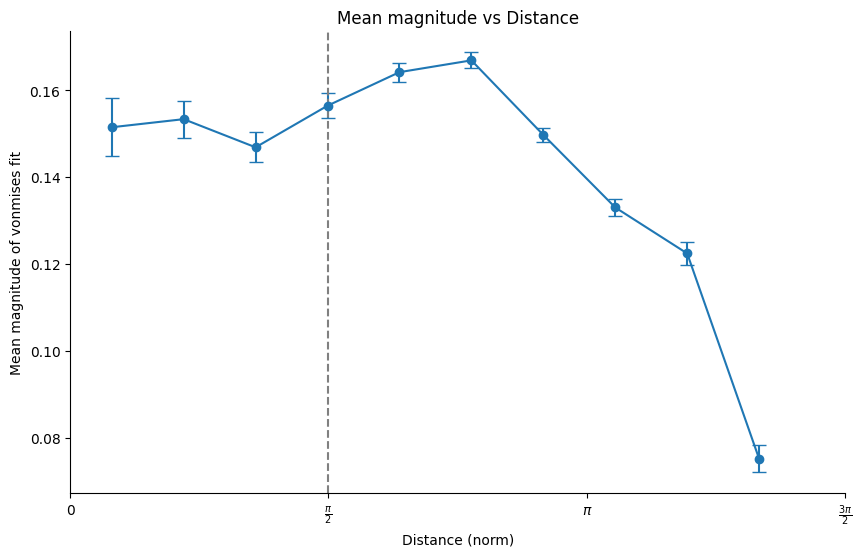

In [180]:
# mean 'reward' vs |pos_a-pos_dot|, v3

import matplotlib.pyplot as plt
%matplotlib inline

N = 200  # trials
B = 10  # bins
I = 2 # init (ignore)

v_pred_arr_ = np.clip(v_pred_arr[:,I:,:],0,1)
x_y_coords = gen_vectors(np.int32(np.sqrt(v_pred_arr_.shape[2])), np.pi)

mean_mag_arr = np.zeros((N, v_pred_arr_.shape[1]))
# ell_time_arr = np.zeros((N, v_pred_arr_.shape[1]))
for i in range(N):
    for t in range(1,v_pred_arr_.shape[1]):
        *_, mean_mag = vonmises_fit(x_y_coords[0, :], x_y_coords[1, :], v_pred_arr_[i, t])
        mean_mag_arr[i, t] = mean_mag

dis_rel = mod_(pos_arr[:N, :, I:] - dot_arr[:N, :, I:])
dis_norm = np.linalg.norm(dis_rel, axis=1, ord=2)

bin_edges = np.linspace(np.min(dis_norm), np.max(dis_norm), B+1)
bin_indices = np.digitize(dis_norm, bin_edges)

bin_means = np.zeros(B)
bin_errors = np.zeros(B)

for j in range(B):  
    mask = (bin_indices == j + 1)
    bin_data = mean_mag_arr[mask].flatten()  # consider all trials and timesteps
    bin_means[j] = np.mean(bin_data)
    bin_errors[j] = np.std(bin_data) / np.sqrt(bin_data.size)  # Standard Error

fig_m, ax_m = plt.subplots(figsize=(10, 6))
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

ax_m.errorbar(bin_centers, bin_means, yerr=bin_errors, fmt='-o', capsize=5) #, label='Mean of VM fit')
ax_m.axvline(x=(np.pi/2), color='grey', linestyle='--')
ax_m.set_title("Mean magnitude vs Distance")
ax_m.set_xlabel("Distance (norm)")
ax_m.set_ylabel("Mean magnitude of vonmises fit")
ticks = [0, np.pi/2, np.pi, 3*np.pi/2]
labels = ['0', r'$\frac{\pi}{2}$', r'$\pi$', r'$\frac{3\pi}{2}$']
ax_m.set_xticks(ticks)
ax_m.set_xticklabels(labels)
ax_m.spines['right'].set_visible(False)
ax_m.spines['top'].set_visible(False)
# ax_m.legend()
plt.show()


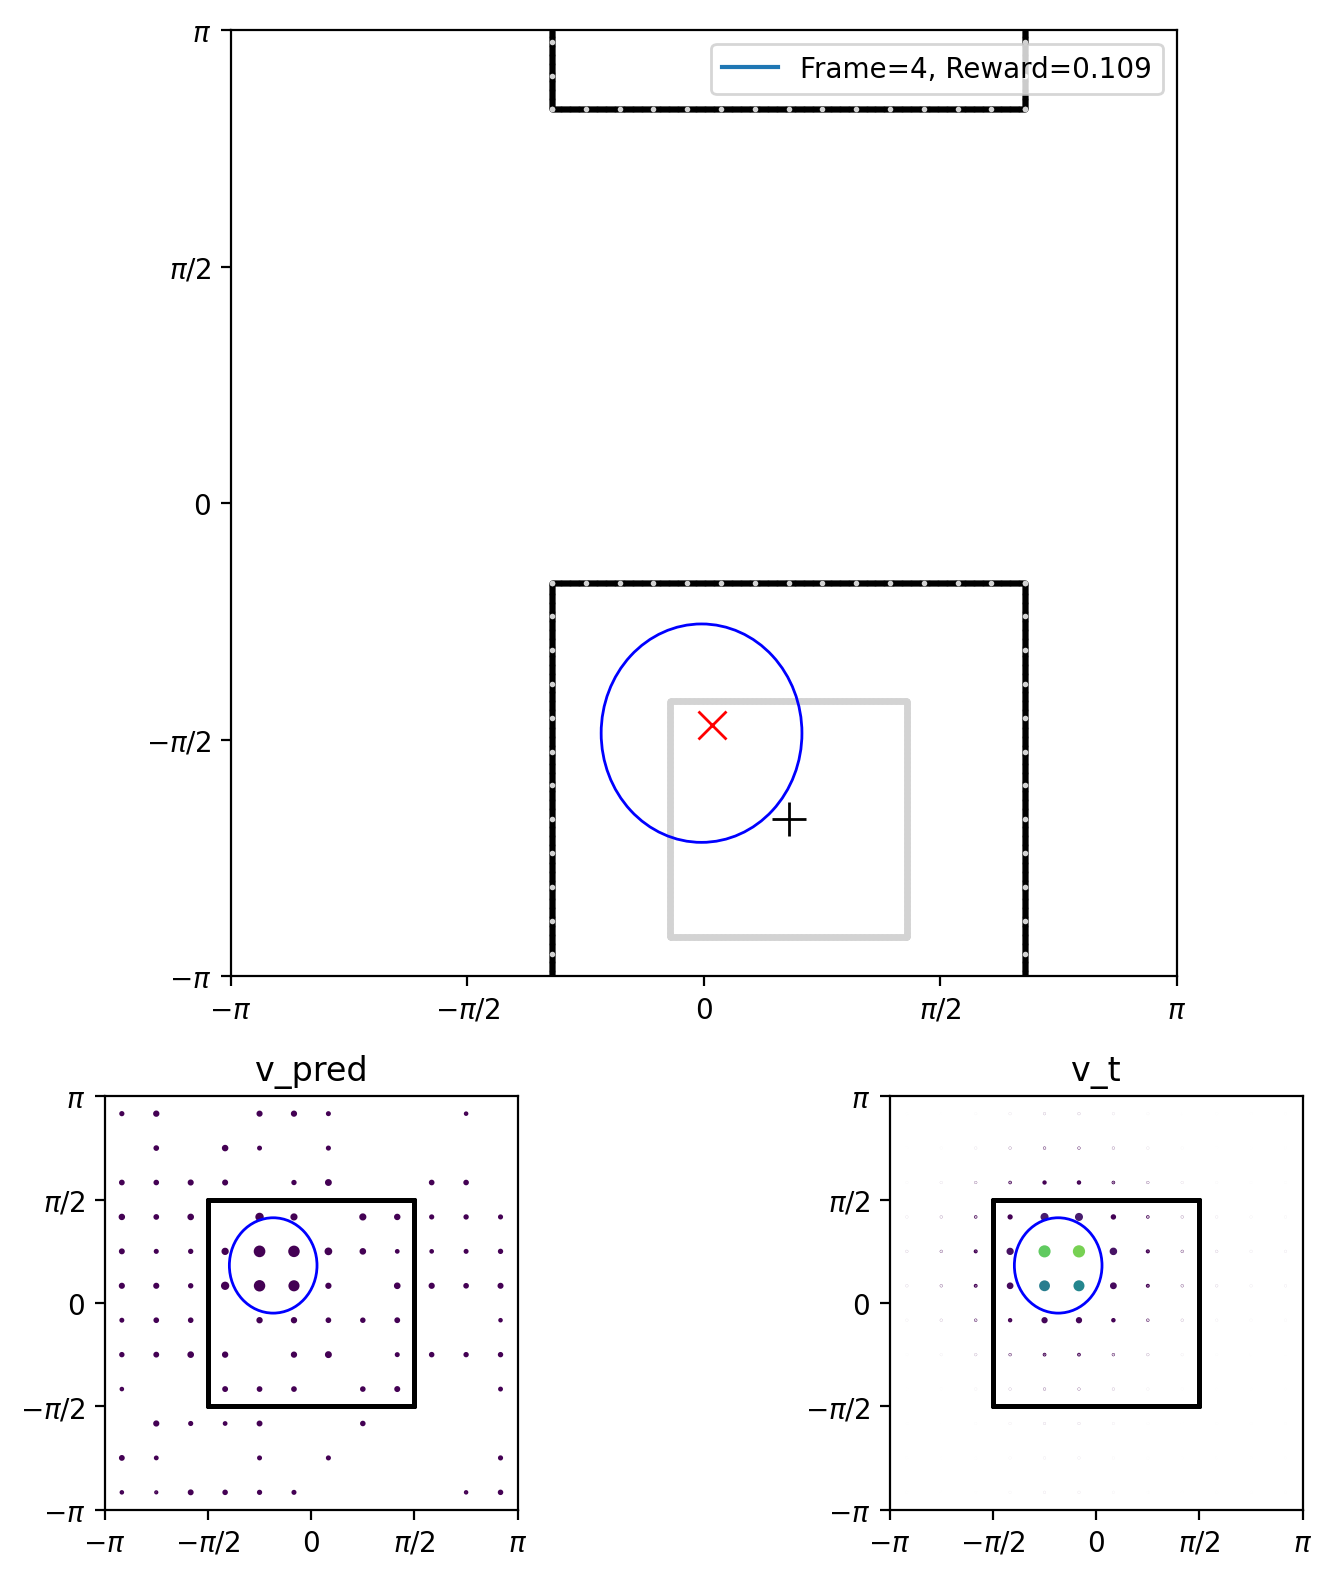

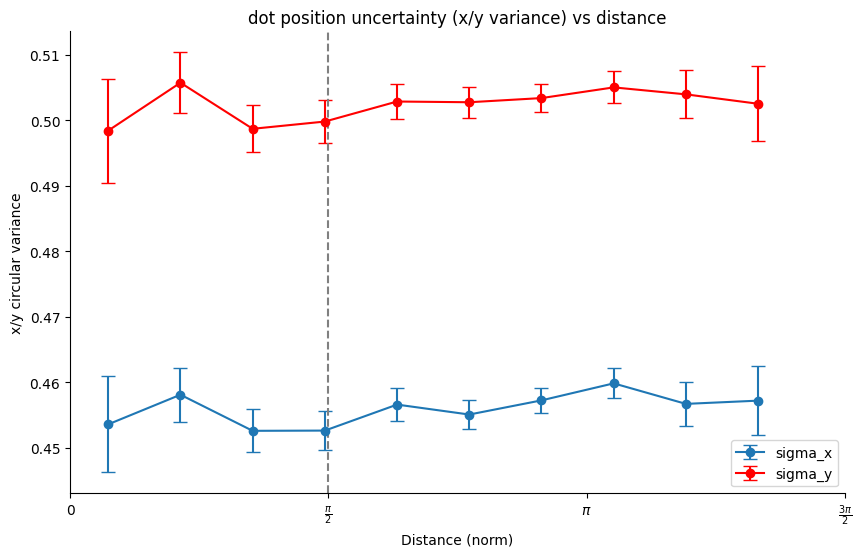

In [4]:
# mean 'reward' vs |pos_a-pos_dot|, v3

import matplotlib.pyplot as plt
%matplotlib inline

N = 500  # trials
B = 10  # bins
I = 2 # init (ignore)

v_pred_arr_ = np.clip(v_pred_arr[:,I:,:],0,1)
x_y_coords = gen_vectors(np.int32(np.sqrt(v_pred_arr_.shape[2])), np.pi)

sigma_x_arr = np.zeros((N, v_pred_arr_.shape[1]))
sigma_y_arr = np.zeros((N, v_pred_arr_.shape[1]))
# ell_time_arr = np.zeros((N, v_pred_arr_.shape[1]))
for i in range(N):
    for t in range(1,v_pred_arr_.shape[1]):
        *_,mean_x,mean_y,sigma_x,sigma_y = circ_mean_var(v_pred_arr[i, t],np.pi)
        sigma_x_arr[i, t] = sigma_x
        sigma_y_arr[i, t] = sigma_y

dis_rel = mod_(pos_arr[:N, :, I:] - dot_arr[:N, :, I:])
dis_norm = np.linalg.norm(dis_rel, axis=1, ord=2)

bin_edges = np.linspace(np.min(dis_norm), np.max(dis_norm), B + 1)
bin_edges[0] = bin_edges[0] - 1e-5
bin_edges[-1] = bin_edges[-1] + 1e-5
bin_indices = np.digitize(dis_norm, bin_edges)

# Initialize arrays for means and standard errors
bin_means_sigma_x = np.zeros(B)
bin_means_sigma_y = np.zeros(B)
bin_errors_sigma_x = np.zeros(B)
bin_errors_sigma_y = np.zeros(B)

for j in range(B):
    mask = (bin_indices == j + 1)
    bin_data_x = sigma_x_arr[mask].flatten()
    bin_data_y = sigma_y_arr[mask].flatten()
    bin_means_sigma_x[j] = np.mean(bin_data_x)
    bin_means_sigma_y[j] = np.mean(bin_data_y)
    bin_errors_sigma_x[j] = np.std(bin_data_x)/ np.sqrt(bin_data_x.size)  # Standard Error
    bin_errors_sigma_y[j] = np.std(bin_data_y)/ np.sqrt(bin_data_y.size)  # Standard Error

# Plotting
fig_s, ax_s = plt.subplots(figsize=(10, 6))
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# plot sigma_x/y
ax_s.errorbar(bin_centers, bin_means_sigma_x, yerr=bin_errors_sigma_x, fmt='-o', capsize=5, label='sigma_x')
ax_s.errorbar(bin_centers, bin_means_sigma_y, yerr=bin_errors_sigma_y, fmt='-o', capsize=5, color='red', label='sigma_y')

# ax_s.set_ylim([0, None])
ax_s.axvline(x=(np.pi/2), color='grey', linestyle='--')
ax_s.set_title("dot position uncertainty (x/y variance) vs distance")
ax_s.set_xlabel("Distance (norm)")
ax_s.set_ylabel("x/y circular variance")
ticks = [0, np.pi/2, np.pi, 3*np.pi/2]
labels = ['0', r'$\frac{\pi}{2}$', r'$\pi$', r'$\frac{3\pi}{2}$']
ax_s.set_xticks(ticks)
ax_s.set_xticklabels(labels)
ax_s.spines['right'].set_visible(False)
ax_s.spines['top'].set_visible(False)
ax_s.legend()

plt.show()

In [5]:
# full ani v2
%matplotlib qt
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.animation as animation
import functools

def mod_(x):
    return (x + np.pi) % (2 * np.pi) - np.pi

def gen_vectors(MODULES, APERTURE):
    m = MODULES
    A = APERTURE
    x = np.linspace(-(A-A/m), (A-A/m), m)
    x_ = np.tile(x, (m, ))
    y_ = np.repeat(np.flip(x), m)
    return np.vstack([x_, y_])

def set_axis_properties(ax,lim,labels,title=''):
    ax.set_xlim(-lim,lim)
    ax.set_ylim(-lim,lim)
    ax.set_aspect('equal', 'box')  
    ax.set_title(title)
    ticks = np.linspace(-lim,lim,5)
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)

def get_aperture_points(agent_t,aperture,density=100):
    x_horizontal = np.linspace(agent_t[0] - aperture, agent_t[0] + aperture, density)
    y_top = np.full(density, agent_t[1] + aperture)
    y_bottom = np.full(density, agent_t[1] - aperture)
    y_vertical = np.linspace(agent_t[1] - aperture, agent_t[1] + aperture, density)
    x_left = np.full(density, agent_t[0] - aperture)
    x_right = np.full(density, agent_t[0] + aperture)
    x_tot = np.concatenate([x_left, x_right, x_horizontal, x_horizontal])
    y_tot = np.concatenate([y_vertical, y_vertical, y_bottom, y_top])
    return x_tot, y_tot

def animate(i,v_pred_arr,v_t_arr,dot_arr,dot_hat_arr,pos_arr,dot,dot_hat,agent,neuron_locs,scatters_pred,scatters_t,aperture_points,act_space_points):
    # initialize
    dot.set_data(mod_(dot_arr[i, 0]), mod_(dot_arr[i, 1]))
    agent.set_data(mod_(pos_arr[i, 0]), mod_(pos_arr[i, 1]))
    dot_hat.set_data(mod_(dot_hat_arr[i, 0]), mod_(dot_hat_arr[i, 1]))
    # aperture color
    if i == 0:
        aperture_points.set_color('green')
    else:
        aperture_points.set_color('black')
    # Update v_pred_arr
    scatters_pred.set_offsets(neuron_locs.T)
    scatters_pred.set_array(v_pred_arr[i])
    scatters_pred.set_sizes(17 * v_pred_arr[i])
    scatters_pred.set_facecolors('k')
    # Update v_t_arr
    scatters_t.set_offsets(neuron_locs.T)
    scatters_t.set_array(v_t_arr[i])
    scatters_t.set_sizes(17 * v_t_arr[i])
    scatters_t.set_facecolors('k')
    x_aperture,y_aperture = get_aperture_points(pos_arr[i],APERTURE)
    aperture_points.set_offsets(np.c_[mod_(x_aperture), mod_(y_aperture)])
    x_act_space,y_act_space = get_aperture_points(pos_arr[i],ACT_SPACE)
    act_space_points.set_offsets(np.c_[mod_(x_act_space), mod_(y_act_space)])
    return [dot,agent,dot_hat,scatters_pred,scatters_t,aperture_points,act_space_points]

k = 313 # 0_i,313,216,188_d,
interval = 300
APERTURE = np.pi/2
ACT_SPACE = np.pi/5
STEPS = v_pred_arr.shape[1]
MODULES = 15 # 17 # 15
NEURONS_AP = 5 # 10 # 5
NEURONS_FULL = np.int32(NEURONS_AP*(np.pi//APERTURE))

neuron_locs = gen_vectors(NEURONS_FULL,ACT_SPACE) # NEURONS
v_pred_arr_ = np.clip(v_pred_arr[k,:],0,1)
v_t_arr_ = v_t_arr[k,:]
dot_arr_ = dot_arr[k,:,:].T # [STEPS,2]
pos_arr_ = pos_arr[k,:,:].T # [STEPS,2]
rel_vec_hat_arr_ = rel_vec_hat_arr[k,:,:] # [STEPS,2]
dot_hat_arr_ = mod_(rel_vec_hat_arr_ + pos_arr_)

fig = plt.figure(figsize=(8, 12))
gs = gridspec.GridSpec(3, 2, height_ratios=[1, 1, 1])

ax_ani = plt.subplot(gs[0:2, 0:2],aspect='equal')
agent, = ax_ani.plot(mod_(pos_arr_[0, 0]), mod_(pos_arr_[0, 1]), 'k+', markersize=12, label='dot')
dot, = ax_ani.plot(mod_(dot_arr_[0, 0]), mod_(dot_arr_[0, 1]), 'rx', markersize=10, label='agent')
dot_hat, = ax_ani.plot(mod_(dot_hat_arr_[0, 0]), mod_(dot_hat_arr_[0, 1]), 'bx', markersize=10, label='dot_hat')

set_axis_properties(ax_ani,jnp.pi,["$-\pi$", "$-\pi/2$", "0", "$\pi/2$", "$\pi$"])

ax_pred = plt.subplot(gs[2, 0], aspect='equal')
# update scatter
scatters_pred = ax_pred.scatter(
    neuron_locs[0, :], neuron_locs[1, :], 
    c='k', # v_pred_arr_[0], 
    s=17 * v_pred_arr_[0], 
    marker='o',
    vmin=0, vmax=1
)
set_axis_properties(ax_pred, ACT_SPACE, ["$-\pi/5$", "$-\pi/10$", "0", "$\pi/10$", "$\pi/5$"], 'v_pred')

ax_t = plt.subplot(gs[2, 1], aspect='equal')
# update scatter
scatters_t = ax_t.scatter(
    neuron_locs[0, :], neuron_locs[1, :], 
    c='k', # v_t_arr_[0], 
    s=17 * v_t_arr_[0], 
    marker='o',
    vmin=0, vmax=1  # Assuming activations range from 0 to 1
)
set_axis_properties(ax_t, ACT_SPACE, ["$-\pi/5$", "$-\pi/10$", "0", "$\pi/10$", "$\pi/5$"], 'v_t')

aperture_points = ax_ani.scatter([], [], color='black', s=1)
act_space_points = ax_ani.scatter([], [], color='lightgrey', s=1)

partial_animate = functools.partial(
    animate,
    v_pred_arr=v_pred_arr_, 
    v_t_arr=v_t_arr_, 
    dot_arr=dot_arr_, 
    dot_hat_arr=dot_hat_arr_,
    pos_arr=pos_arr_, 
    dot=dot, 
    dot_hat=dot_hat,
    agent=agent, 
    neuron_locs=neuron_locs, 
    scatters_pred=scatters_pred, 
    scatters_t=scatters_t,
    aperture_points=aperture_points,
    act_space_points=act_space_points,
)

ani = animation.FuncAnimation(
    fig=fig, 
    func=partial_animate,
    frames=STEPS, 
    blit=True, 
    interval=interval
)

plt.tight_layout()
plt.show()

/var/folders/hp/sdqbmwnd5m14lcp1k2qjnkx00000gn/T/ipykernel_11188/1757618560.py:97: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  scatters_pred = ax_pred.scatter(
/var/folders/hp/sdqbmwnd5m14lcp1k2qjnkx00000gn/T/ipykernel_11188/1757618560.py:108: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  scatters_t = ax_t.scatter(
/var/folders/hp/sdqbmwnd5m14lcp1k2qjnkx00000gn/T/ipykernel_11188/1757618560.py:44: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  dot.set_data(mod_(dot_arr[i, 0]), mod_(dot_arr[i, 1]))
/var/folders/hp/sdqbmwnd5m14lcp1k2qjnkx00000gn/T/ipykernel_11188/1757618560.py:45: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  agent.set_data(mod_(pos_arr[i, 0]), mod_(pos_arr[i, 1]))
/var/folders/hp/sdq

In [ ]:
# analysis:

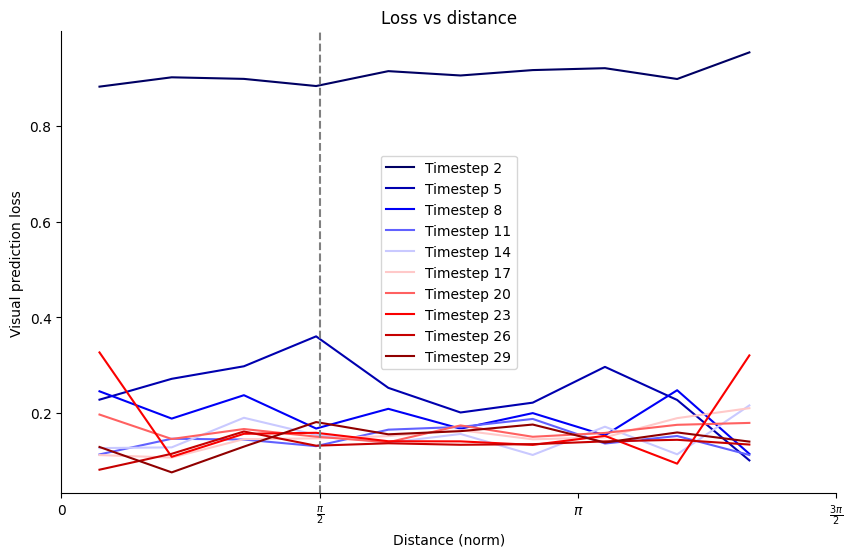

In [6]:
# l vs |pos_a-pos_dot|, v2/3
%matplotlib inline
# plot avg loss of visual prediction (l vs |pos_a-pos_dot|) at each timestep
loss = loss_v_arr_ # l = jnp.mean(loss_v_arr_,axis=0) # [500,6]->[6,]
dis_rel = mod_(pos_arr - dot_arr)
dis_norm = jnp.linalg.norm(dis_rel,axis=1,ord=2)[:,1:] # d = jnp.mean(jnp.abs(pos_arr - dot_arr),axis=0)[:,-1] # [500,2,7]->[2,7]
STEPS = loss_v_arr_.shape[1]
# bin distance norms
num_bins = 10
bin_edges = jnp.linspace(jnp.min(dis_norm), jnp.max(dis_norm), num_bins+1)
bin_indices = jnp.digitize(dis_norm, bin_edges)
# group losses for each timestep,bin
bin_means = jnp.zeros((num_bins, STEPS))
for i in range(STEPS):  # for each timestep
    for j in range(num_bins):  # for each bin
        mask = (bin_indices[:, i] == j + 1)  # +1 because digitize returns 1-based binning
        bin_means = bin_means.at[j, i].set(jnp.mean(loss[mask, i]))
# plot
fig,ax = plt.subplots(figsize=(10,6))
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
cmap = cm.seismic(jnp.linspace(0, 1, STEPS))
for i in jnp.arange(1,STEPS,3): # ,3
    plt.plot(bin_centers, bin_means[:, i],color=cmap[i], label=f'Timestep {i+1}')
plt.axvline(x=(np.pi/2), color='grey', linestyle='--') #, label='aperture')  # Adding the vertical line
plt.title("Loss vs distance")
plt.xlabel("Distance (norm)")
plt.ylabel("Visual prediction loss")
ticks = [0, np.pi/2, np.pi, 3*np.pi/2]
labels = ['0', r'$\frac{\pi}{2}$', r'$\pi$', r'$\frac{3\pi}{2}$']
plt.xticks(ticks, labels)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.legend()
plt.show()

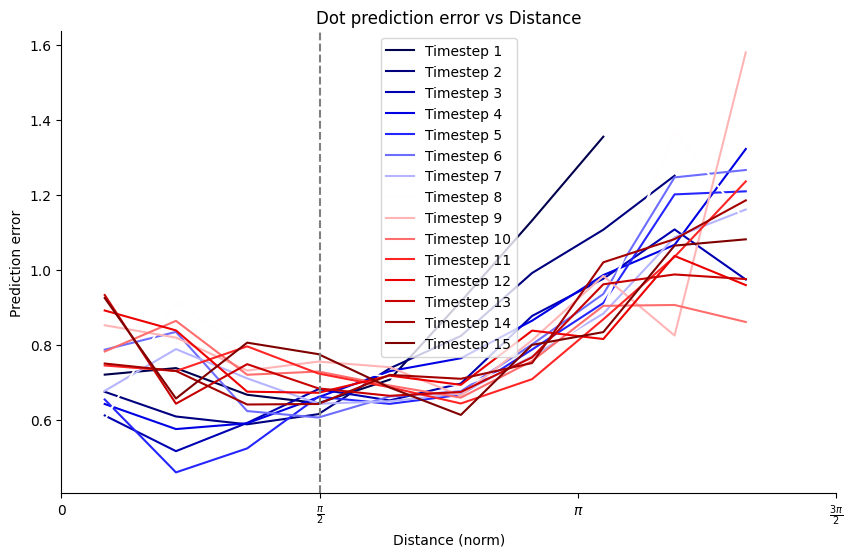

In [21]:
# |pos_dot^-pos_dot| vs |pos_a-pos_dot|, v2
%matplotlib inline

# plot avg distance of dot prediction (|pos_dot^-pos_dot| vs |pos_a-pos_dot|) at each timestep
dis_rel = mod_(pos_arr - dot_arr)
dis_norm = jnp.linalg.norm(dis_rel,axis=1,ord=2)[:,1:] # [15]
dot_hat_arr = rel_vec_hat_arr.transpose(0,2,1)[:,:,1:] + pos_arr[:,:,1:] # [500,2,15]
dot_rel = mod_(dot_hat_arr - dot_arr[:,:,1:])
dot_norm = jnp.linalg.norm(dot_rel,axis=1,ord=2)
STEPS = loss_v_arr_.shape[1]

# bin distance norms
num_bins = 10
bin_edges = jnp.linspace(jnp.min(dis_norm), jnp.max(dis_norm), num_bins+1)
bin_indices = jnp.digitize(dis_norm, bin_edges)

# group losses for each timestep,bin
bin_means = jnp.zeros((num_bins, STEPS))
for i in range(STEPS):  # for each timestep
    for j in range(num_bins):  # for each bin
        mask = (bin_indices[:, i] == j + 1)  # +1 because digitize returns 1-based binning
        bin_means = bin_means.at[j, i].set(jnp.mean(dot_norm[mask, i]))

# plot
fig,ax = plt.subplots(figsize=(10,6))
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
cmap = cm.seismic(jnp.linspace(0, 1, STEPS))
for i in range(STEPS):
    plt.plot(bin_centers, bin_means[:, i], color=cmap[i],label=f'Timestep {i+1}')
plt.axvline(x=np.pi/2, color='grey', linestyle='--') #, label='aperture')  # Adding the vertical line
plt.title("Dot prediction error vs Distance")
plt.xlabel("Distance (norm)")
plt.ylabel("Prediction error")
ticks = [0, np.pi/2, np.pi, 3*np.pi/2]
labels = ['0', r'$\frac{\pi}{2}$', r'$\pi$', r'$\frac{3\pi}{2}$']
plt.xticks(ticks, labels)
plt.legend()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()

trial_loss= (30,) [0.         0.87708324 1.0948808  1.1135684  1.1567084  1.2056034  0.7758479  0.06278299 0.6231886  0.07518958 0.04959535 0.044429   0.11174597 0.04798212 0.05264279 0.08040357 0.09569044 0.06572618
 0.10163927 0.04990733 0.03511589 0.0729799  0.05826134 0.1291876  0.036204   0.06511103 0.04151199 0.05508875 0.13202012 0.31784758]
dis_norm_trial= (30,) [1.2838743  3.6290617  3.553854   3.0590677  3.3656065  3.856924   2.1562717  3.299712   2.4197607  1.0766246  0.682253   2.9177759  2.0657241  2.967088   0.63602364 1.6208936  1.5005286  2.368428
 2.0894213  0.5445593  1.593989   0.33330578 2.3307095  2.164161   2.028417   2.842322   3.221885   3.4850223  3.2084308  1.9082524 ]


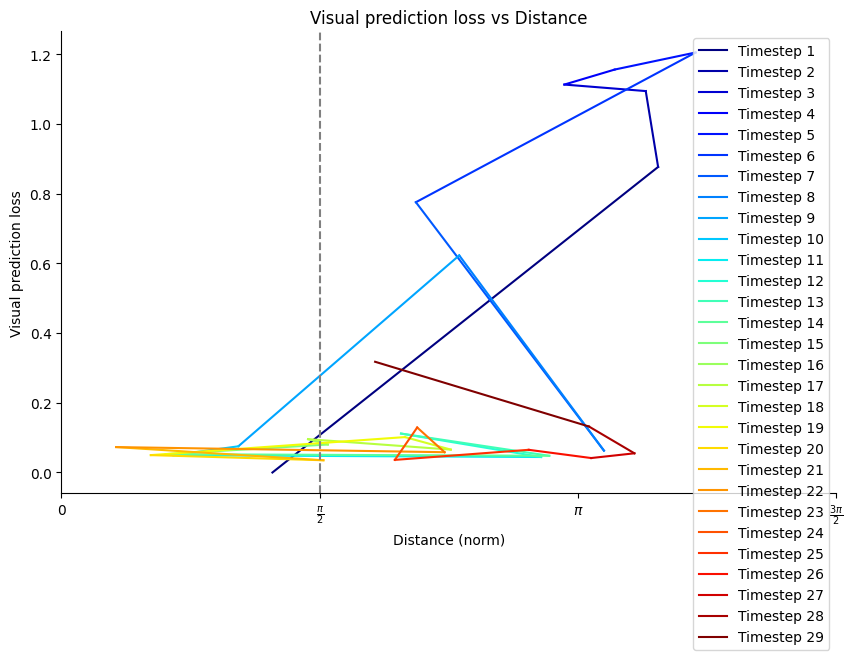

In [144]:
# single trial loss, v2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

k = 0 # 0 
trial_loss = loss_v_arr_[k, :] # [500,15]->[15]
print('trial_loss=',trial_loss.shape, trial_loss)
dis_rel_trial = mod_(pos_arr[k,:,:] - dot_arr[k,:,:]) # [500,2,16]
dis_norm_trial = np.linalg.norm(dis_rel_trial, axis=0, ord=2) # [15]
print('dis_norm_trial=',dis_norm_trial.shape, dis_norm_trial)

# Create a colormap based on the timestep
colors = cm.jet(np.linspace(0, 1, len(trial_loss)-1))

fig, ax = plt.subplots(figsize=(10, 6))
for i in range(len(trial_loss) - 1):
    ax.plot(dis_norm_trial[i:i+2], trial_loss[i:i+2], color=colors[i], label=f'Timestep {i+1}')

plt.axvline(x=np.pi/2, color='grey', linestyle='--') #, label='aperture')  # Adding the vertical line
plt.title("Visual prediction loss vs Distance")
plt.xlabel("Distance (norm)")
plt.ylabel("Visual prediction loss")
ticks = [0, np.pi/2, np.pi, 3*np.pi/2]
labels = ['0', r'$\frac{\pi}{2}$', r'$\pi$', r'$\frac{3\pi}{2}$']
plt.xticks(ticks, labels)
plt.legend()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()


dot_norm_trial= (15,) [0.28459156 0.56269    0.03847573 0.5399476  1.0350604  1.0535816  1.209862   1.3800495  1.2799846  0.7060281  0.54155403 1.1440424  0.51013017 0.50707984 0.13982336]
dis_norm_trial= (15,) [0.40666673 0.2464029  0.2596683  0.7641156  1.7881247  2.8665788  3.762945   3.745823   3.034902   2.50046    1.9913093  1.0279361  0.5961062  0.7609206  0.776146  ]


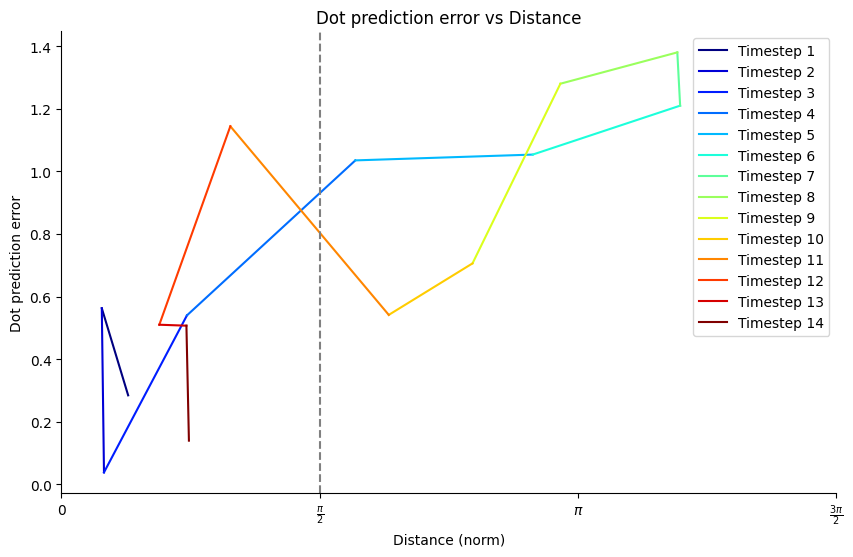

In [23]:
# single trial error, v2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

k = 0  # for example
dot_hat_arr_trial = rel_vec_hat_arr.transpose(0,2,1)[k,:,1:] + pos_arr[k,:,1:]
dot_rel_trial = mod_(dot_hat_arr_trial - dot_arr[k,:,1:])
dot_norm_trial = jnp.linalg.norm(dot_rel_trial,axis=0,ord=2)
print('dot_norm_trial=', dot_norm_trial.shape, dot_norm_trial)
dis_rel_trial = mod_(pos_arr[k,:,1:] - dot_arr[k,:,1:])
dis_norm_trial = jnp.linalg.norm(dis_rel_trial,axis=0,ord=2) # [15]
print('dis_norm_trial=', dis_norm_trial.shape, dis_norm_trial)
STEPS = loss_v_arr_.shape[1]

colors = cm.jet(np.linspace(0, 1, len(dot_norm_trial)-1))
fig, ax = plt.subplots(figsize=(10, 6))
for i in range(len(dot_norm_trial) - 1):
    ax.plot(dis_norm_trial[i:i+2], dot_norm_trial[i:i+2], color=colors[i], label=f'Timestep {i+1}')

plt.title("Dot prediction error vs distance for a single trial")
plt.axvline(x=np.pi/2, color='grey', linestyle='--') #, label='aperture')  # Adding the vertical line
plt.title("Dot prediction error vs Distance")
plt.xlabel("Distance (norm)")
plt.ylabel("Dot prediction error")
ticks = [0, np.pi/2, np.pi, 3*np.pi/2]
labels = ['0', r'$\frac{\pi}{2}$', r'$\pi$', r'$\frac{3\pi}{2}$']
plt.xticks(ticks, labels)
plt.legend()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()